# FairClaim: Fraud Detection for Sustainable Insurance
notebook 1

## Table of Contents

- [Problem Definition & Context](#problem-definition-context)
- [Dataset Selection & Description](#dataset-selection-description)
- [Primary Success Criteria](#primary-success-criteria)
- [Dataset overview and sanity snapshots](#dataset-overview-and-sanity-snapshots)
- [Data Quality, Distributions, and Signal Checks](#data-quality-distributions-andsignal-checks)
- [Target distribution & peak behaviour](#target-distribution-peak-behaviour)
- [EDA Conclusions](#eda-conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

## <a id="problem-definition-context"></a>Problem Definition & Context

### 1 Clear classification problem statement

We address a binary classification problem in the context of motor insurance claims.
Each claim is described by policy, vehicle, driver and incident characteristics, and labelled as either:

`FraudFound_P` = 1 – fraudulent claim,

`FraudFound_P` = 0 – legitimate claim.

The goal is to build a model that, given a new claim’s attributes at the time of reporting, predicts whether the claim is potentially fraudulent (positive class) or likely legitimate (negative class). The model outputs a fraud-risk score and a binary decision that can be used to prioritise cases for further human investigation. 

We treat `FraudFound_P` as the **insurer-provided fraud label** (fraud found/flagged). Due to missing official documentation, we cannot confirm whether it represents confirmed fraud or suspected fraud, but we assume it reflects the insurer’s final labeling decision used for historical supervision.

### 2 Hypothesis: what the model will predict and why it matters

My working hypothesis is that fraudulent claims follow different patterns than legitimate ones across a combination of features, such as:

- timing of the accident vs. timing of the claim (`Month`, `WeekOfMonth`, `Days_Policy_Accident`, `Days_Policy_Claim`),

- policy and vehicle characteristics (`PolicyType`, `VehicleCategory`, `VehiclePrice`, `AgeOfVehicle`, `AgeOfPolicyHolder`, `DriverRating`, `Deductible`),

- contextual signals (`AccidentArea`, `PoliceReportFiled`, `WitnessPresent`, `PastNumberOfClaims`, `AddressChange_Claim`, `NumberOfSuppliments`).

If these patterns are learnable, a supervised model can:

- assign higher fraud scores to claims whose feature combinations are more typical for past fraudulent cases than for legitimate ones,

- achieve a **high recall** on the minority fraud class, while keeping the overall alert volume (false positives) at a manageable level.

This matters because each **false negative (missed fraud)** directly increases the insurer’s financial loss and indirectly raises premiums for honest customers. At the same time, too many false positives (legitimate claims flagged as fraud) overload investigation teams and may damage customer trust. A good model should therefore reduce undetected fraud while avoiding an excessive number of unnecessary alerts.

### 3 Societal / sustainability relevance and stakeholders

This project is closely related to social and economic sustainability:

Persistent insurance fraud can make the whole system less sustainable:
honest customers end up subsidising fraud through higher premiums or reduced coverage.

More accurate fraud detection allows the insurer to limit financial leakage and keep pricing fairer and more stable for the majority of policyholders.

A transparent, well-governed model can also increase trust in the claims process by making investigations more consistent and evidence-based, rather than ad-hoc or purely manual.

**Key stakeholders include:**

- Insurance company management, who care about financial losses, risk exposure, and long-term business sustainability.

- Fraud investigation / claims teams, who need prioritised and interpretable alerts, not a black-box that floods them with false positives.

- Honest policyholders, who are affected by both undetected fraud (higher premiums, stricter conditions) and unfair suspicion (being incorrectly flagged as high-risk).

- Regulators and consumer protection bodies, who are interested in ensuring that automated decision-support systems are fair, non-discriminatory, and do not lead to unjust claim denials.

In this project, I treat the model as a decision-support tool inside a human-in-the-loop process: it should help allocate investigative resources more efficiently and support a more sustainable, trustworthy insurance system, rather than replace human judgement or automatically reject claims.

## <a id="dataset-selection-description"></a>Dataset Selection & Description

### 1 Rationale for chosen dataset and target variable

For this project, I use the “Vehicle Insurance Claim Fraud Detection” dataset, which contains historical motor insurance claims labelled as either fraudulent or legitimate. This dataset is a good fit for several reasons:

- It defines a clear binary target variable, `FraudFound_P`, indicating whether each claim was identified as fraud (1) or not (0).

- The dataset is substantially imbalanced (only about 6% of claims are labelled as fraud), which reflects real-world fraud detection scenarios and makes it well-suited for studying class imbalance, cost-sensitive decisions, and evaluation beyond simple accuracy.

- With over 15,000 rows and 30+ features, it provides enough signal and complexity to train and compare different classical ML models (logistic regression, tree-based methods, etc.) without requiring deep learning or massive compute.

- The features are primarily structured, tabular attributes about the policy, vehicle, driver, and incident context, which aligns well with the course focus on classical ML and interpretability.

In the context of this challenge, I treat “fraudulent claim” as the positive class. The objective is not just to predict this label, but to explore how well different models can detect rare fraud cases while controlling false alarms, and what trade-offs this implies for business decisions and fairness.

### 2 Data source, access, and licensing / ethical considerations

The data is obtained from the Kaggle dataset “Vehicle Insurance Claim Fraud Detection” (author: Shivam Bansal), which republishes a real insurance company database originally made available by Oracle for educational and demonstration purposes in their fraud detection case studies.

**Licensing:** Kaggle lists this dataset as publicly available for research and educational use; various public projects and academic papers reuse it as a benchmark for insurance fraud detection.

**Anonymisation:** The dataset does not contain direct personal identifiers such as names, addresses or contact details. Policy and claim identifiers are present only as numeric codes and are treated as anonymised technical IDs. As a result, individual policyholders are not directly identifiable from the data.

- The Kaggle source does **not** provide an official feature dictionary.
- We therefore created an **empirical data dictionary** (see `data_dictionary.md`) using:
  - observed value labels
  - naming conventions and distribution sanity checks.
- **Working target interpretation:** `FraudFound_P` is an **insurer-provided fraud label** (fraud found/flagged historically).  
  We cannot confirm whether it represents *confirmed* vs *suspected* fraud due to missing official documentation.

We assume a practical fraud-scoring setting where most features are available by claim filing time, while some variables may be populated during claim handling (e.g., `NumberOfSuppliments`, `RepNumber`).  
We therefore evaluate models under two feature availability scenarios later:
1) **Claim submission** (exclude process-like variables)
2) **Claim handling** (include them)

**Ethical caveats:**

The fraud labels reflect historical decisions by investigators and internal rules, which may embed existing biases or inconsistencies; the model can therefore learn and reinforce those patterns rather than any “objective ground truth”.

The dataset comes from a single insurance company and context, so it may not be representative of other markets, products, or populations.

In any realistic deployment, such a model should be used as decision-support, not as an automatic rejection tool, and would need to comply with data protection and anti-discrimination regulations.

In this project, I explicitly treat the dataset as an educational benchmark, and assume a hypothetical deployment scenario where the model only prioritises claims for human review in a human-in-the-loop process.

### 3 Initial structural properties and concerns

Without going into detailed feature analysis yet, there are a few important structural aspects and concerns that shape the rest of the work:

The dataset contains 15,420 claims and 33 features, with a mix of numerical and categorical variables.

The target variable FraudFound_P is highly imbalanced, with only around 6% of claims labelled as fraudulent. This makes standard metrics like accuracy potentially misleading and requires careful attention to recall, precision, and possibly cost-sensitive evaluation.

Because of the real-world origin of the data (a single insurer, time period, and market), there is a risk of sampling bias and label bias: the patterns the model learns may mirror past investigative habits rather than unbiased fraud behaviour.

These points motivate a strong focus, later in the project, on evaluation choices, threshold selection, and fairness checks, not just on maximising a single performance number.

### 4 Features

Full list of features and possible discription given in data dictionary file added to this submission

## <a id="primary-success-criteria"></a>Primary Success Criteria

### Objective framing: ranking + investigation capacity (Top-K)

This project treats fraud detection as a **prioritization problem**, not an auto-decision system.  
The model outputs a fraud-risk score, and the insurer investigates only a limited fraction of claims due to constrained resources.

Therefore, success is defined by:
1) **how well the model ranks fraudulent claims above legitimate ones** (threshold-free ranking metrics), and  
2) how effective the model is under a realistic **Top-K investigation policy** (capacity-driven evaluation).


### Primary selection metric for model choice

**PR-AUC (Average Precision) on out-of-time validation** is the **primary** model selection metric.

- **Why PR-AUC:** the dataset is imbalanced. PR-AUC is more informative than accuracy and is sensitive to performance on the fraud class.
- **Secondary metric:** ROC-AUC, to confirm that the model learns meaningful ranking signal.

We use **time-based validation** (train 1994 -> validate 1995) for selection to reflect next-year generalization.


### Operational success criteria (business-facing)

Because investigations are capacity-limited, we evaluate operational value using **Top-K prioritization metrics** on the held-out test year:

For K ∈ {1%, 5%, 10%, 20%}:
- **Precision@K:** how fraud-dense the investigated queue is  
- **Recall@K (capture rate):** what fraction of all fraud cases in the year is captured by investigating top K%  
- **Lift@K:** how much better the queue is compared to random selection (Lift > 1 indicates operational value)
- **TP / FP / FN counts** to make workload and missed-fraud trade-offs explicit

**Interpretation:** the business chooses K based on available investigation resources and acceptable missed-fraud level.  
We do not set a single universal recall target (e.g., 90%), because in capacity-driven workflows recall depends on K.


### Fairness and robustness checks (sanity-level)

We do not claim to fully solve fairness, but we include basic checks to surface potential issues.

- Inspect whether the model’s strongest drivers are primarily **process/product signals** rather than sensitive attributes (supported by SHAP).
- For selected semi-sensitive attributes (e.g., Sex, Age bands, AccidentArea), compare:
  - fraud prevalence by group (context),
  - investigation inclusion rates under Top-K (who gets flagged more often),
  - and, where feasible, error rates (FP/FN) by group.

If strong disparities appear, they will be documented and discussed as risks (especially if they could lead to disproportionate investigations for specific groups).



### Evaluation procedure

**Temporal evaluation protocol:**
- Train / selection: **1994 → 1995**
- Final test: train **1994–1995 → 1996**
This reflects real deployment (predicting “future” from “past”) and avoids leakage from random splits across years.
We intentionally do not use random stratified split because our goal is next-year generalization; temporal drift makes random splits overly optimistic.

**Workflow:**
1) Build a transparent baseline (Logistic Regression) and run ablation / imbalance strategies to understand signal and drift.
2) Train a stronger non-linear model (CatBoost) suitable for categorical-heavy tabular data.
3) Choose model/hyperparameters using **PR-AUC on Val 1995** (primary).
4) Report final performance on **Test 1996**, including:
   - PR curve (ranking quality),
   - Top-K tables/plots (capacity-driven operational utility),
   - error analysis (missed fraud under Top-20%),
   - SHAP explanations (global drivers + case-level reasoning),
   - limitations and ethical reflection.

This plan ensures the model is evaluated not only by label prediction, but by how well it supports a realistic and socially responsible fraud investigation workflow.

## <a id="dataset-overview-and-sanity-snapshots"></a>Dataset overview and sanity snapshots

In [2]:
df = pd.read_csv('PATH/fraud_oracle.csv') # your path here

In [3]:
df.head(10)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
5,Oct,4,Friday,Honda,Urban,Wednesday,Nov,1,Male,Single,...,5 years,21 to 25,No,No,External,3 to 5,no change,1 vehicle,1994,Collision
6,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,...,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
8,Dec,4,Saturday,Honda,Urban,Wednesday,Dec,5,Male,Single,...,6 years,31 to 35,No,Yes,External,3 to 5,no change,1 vehicle,1994,Collision
9,Apr,3,Tuesday,Ford,Urban,Wednesday,Apr,3,Male,Married,...,more than 7,36 to 40,No,No,External,3 to 5,no change,1 vehicle,1994,All Perils


In [4]:
df.shape

(15420, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [6]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df['Year'].unique()

array([1994, 1995, 1996])

In [9]:
overview = pd.DataFrame({
    "feature": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "n_unique": [df[c].nunique() for c in df.columns],
}).sort_values(["dtype","n_unique"], ascending=[True, False])

overview

,feature,dtype,n_unique
16,PolicyNumber,int64,15420
10,Age,int64,66
17,RepNumber,int64,16
1,WeekOfMonth,int64,5
7,WeekOfMonthClaimed,int64,5
18,Deductible,int64,4
19,DriverRating,int64,4
31,Year,int64,3
15,FraudFound_P,int64,2
3,Make,object,19


In [10]:
df['Year'].value_counts()

Year
1994    6142
1995    5195
1996    4083
Name: count, dtype: int64

In [11]:
def col_snapshot(df, col, max_uniques=12):
    s = df[col]
    out = {
        "dtype": str(s.dtype),
        "n_unique": s.nunique(dropna=False),
        "examples": list(pd.Series(s.unique()).astype(str)[:max_uniques])
    }
    return out

snap = {c: col_snapshot(df, c) for c in df.columns}
snap["Age"], snap["AgeOfVehicle"], snap["PolicyNumber"]

({'dtype': 'int64',
  'n_unique': 66,
  'examples': ['21',
   '34',
   '47',
   '65',
   '27',
   '20',
   '36',
   '0',
   '30',
   '42',
   '71',
   '52']},
 {'dtype': 'object',
  'n_unique': 8,
  'examples': ['3 years',
   '6 years',
   '7 years',
   'more than 7',
   '5 years',
   'new',
   '4 years',
   '2 years']},
 {'dtype': 'int64',
  'n_unique': 15420,
  'examples': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']})

In [12]:
for c in ["FraudFound_P","Year","PolicyType","Days_Policy_Accident","Days_Policy_Claim",
          "NumberOfSuppliments","AddressChange_Claim","PastNumberOfClaims","NumberOfCars",
          "AgeOfVehicle","AgeOfPolicyHolder","VehiclePrice","Fault","AgentType"]:
    print("\n", c)
    print(df[c].value_counts().head(20))


 FraudFound_P
FraudFound_P
0    14497
1      923
Name: count, dtype: int64

 Year
Year
1994    6142
1995    5195
1996    4083
Name: count, dtype: int64

 PolicyType
PolicyType
Sedan - Collision       5584
Sedan - Liability       4987
Sedan - All Perils      4087
Sport - Collision        348
Utility - All Perils     340
Utility - Collision       30
Sport - All Perils        22
Utility - Liability       21
Sport - Liability          1
Name: count, dtype: int64

 Days_Policy_Accident
Days_Policy_Accident
more than 30    15247
none               55
8 to 15            55
15 to 30           49
1 to 7             14
Name: count, dtype: int64

 Days_Policy_Claim
Days_Policy_Claim
more than 30    15342
15 to 30           56
8 to 15            21
none                1
Name: count, dtype: int64

 NumberOfSuppliments
NumberOfSuppliments
none           7047
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: count, dtype: int64

 AddressChange_Claim
AddressChange_Claim
no change     

In [13]:
df["NumberOfSuppliments"].value_counts()

NumberOfSuppliments
none           7047
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: count, dtype: int64

In [14]:
df.groupby("NumberOfSuppliments")["FraudFound_P"].agg(["mean","count"]).sort_values("mean", ascending=False)

,mean,count
NumberOfSuppliments,,
none,0.066979,7047
1 to 2,0.063881,2489
more than 5,0.050427,3867
3 to 5,0.048091,2017


In [15]:
df.groupby("Year")["FraudFound_P"].mean()

Year
1994    0.066591
1995    0.057940
1996    0.052168
Name: FraudFound_P, dtype: float64

### Dataset Overview conclusions:**

- **Missing values:** none reported by `.info()` (all columns fully non-null)
- **Year coverage (`Year`):**
  - 1994: 6,142
  - 1995: 5,195
  - 1996: 4,083

#### Target (`FraudFound_P`)
- **Positive class:** `1` (fraud)
- **Class balance:**
  - `0`: 14,497 (~94.0%)
  - `1`: 923 (~6.0%)
- **Implication:** strong class imbalance -> **accuracy as metric will not be informative**; later we focus on PR-AUC / recall-precision trade-offs.


#### Key observations from early distributions
- Many categorical columns are **ordinal bins** (e.g., `AgeOfVehicle`, `VehiclePrice`, `AgeOfPolicyHolder`, `Days_Policy_*`).
- Several features are **highly skewed / near-constant**:
  - `Days_Policy_Accident`: ~98.9% `"more than 30"`
  - `Days_Policy_Claim`: ~99.5% `"more than 30"`
  - `AgentType`: mostly `"External"` (Internal is rare)
- `PolicyType` has a clear structured format like `"Sedan - Collision"` suggesting it encodes **(Vehicle group + Coverage)**.

#### ??????????? Mark features for ablation (portability / process-risk)
We will compare model performance with/without these features:

- **Ablation candidate:** `RepNumber`  
  - Evidence: only 16 unique values (rep/agent id).  
  - Risk: may encode operational patterns that are not portable or could act as a proxy for internal processes.

- **Optional ablation (depends on scoring time):** `NumberOfSuppliments`  
  - Evidence: looks like claim-handling artifact, but **fraud rate does not increase** with more supplements (early check suggests it is not a “near-leakage label”).  
  - Decision: keep in a “handling-stage” feature set; exclude in an “at-claim-filing” feature set.

## <a id="data-quality-distributions-andsignal-checks"></a>Data Quality, Distributions, and Signal Checks

Data quality & sanity checks (anomalies, coded-missing, impossible values)

`PolicyType` contains a structured label in the form `"VehicleGroup - CoverageType"` (e.g., `"Sedan - Collision"`).  
We split it into two interpretable components (`VehicleGroup`, `CoverageType`) to:
- analyze distributions and fraud patterns separately for vehicle group vs coverage,
- check redundancy against related columns (e.g., `BasePolicy`, `VehicleCategory`),
- improve interpretability in later reporting and modeling.
We keep the original `PolicyType` unchanged for traceability and comparison.

In [16]:
# Split PolicyType into two interpretable components 

df["VehicleGroup"] = df["PolicyType"].str.split(" - ", n=1).str[0]
df["CoverageType"] = df["PolicyType"].str.split(" - ", n=1).str[1]

df[["PolicyType", "VehicleGroup", "CoverageType"]].head()

,PolicyType,VehicleGroup,CoverageType
0,Sport - Liability,Sport,Liability
1,Sport - Collision,Sport,Collision
2,Sport - Collision,Sport,Collision
3,Sedan - Liability,Sedan,Liability
4,Sport - Collision,Sport,Collision


In [17]:
# sanity check

df["VehicleGroup"].value_counts()

VehicleGroup
Sedan      14658
Utility      391
Sport        371
Name: count, dtype: int64

In [18]:
df["CoverageType"].value_counts()

CoverageType
Collision     5962
Liability     5009
All Perils    4449
Name: count, dtype: int64

Detailed sanity check to see if there are some unexpected counts into weekdays, months, age and other features:

In [19]:
df["MonthClaimed"].value_counts()

MonthClaimed
Jan    1446
May    1411
Mar    1348
Oct    1339
Jun    1293
Feb    1287
Nov    1285
Apr    1271
Sep    1242
Jul    1225
Dec    1146
Aug    1126
0         1
Name: count, dtype: int64

In [20]:
df["DayOfWeekClaimed"].value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: count, dtype: int64

In [21]:
df["Month"].value_counts()

Month
Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: count, dtype: int64

In [22]:
df["DayOfWeek"].value_counts()

DayOfWeek
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: count, dtype: int64

In [23]:
# check if month and dayofweek with 0 is the same line

mask_bad_month = df["MonthClaimed"].astype(str).eq("0")
mask_bad_day = df["DayOfWeekClaimed"].astype(str).eq("0")
mask_bad_age = df["Age"].astype(int).eq(0)

df.loc[mask_bad_month | mask_bad_day, 
       ["MonthClaimed", "DayOfWeekClaimed", "Month", "DayOfWeek", "Year", "Age", "FraudFound_P"]]

,MonthClaimed,DayOfWeekClaimed,Month,DayOfWeek,Year,Age,FraudFound_P
1516,0,0,Jul,Monday,1994,0,0


**Issue:**  
One row contains invalid/coded values `"0"` in `MonthClaimed` and `DayOfWeekClaimed`.

**Evidence:**  
`MonthClaimed == "0"` appears exactly once, and `DayOfWeekClaimed == "0"` appears exactly once — both in the same record (1/15420 rows).  
These tokens are not valid month/day names and likely represent a data-entry or extraction error.

**Options considered:**  
1) Drop the single corrupted row.  
2) Replace `"0"` with missing (`NaN`) and impute using the most frequent category.

**Final decision & rationale:**  
Drop the single corrupted row. Since it affects only 0.0065% of the dataset, removing it avoids introducing synthetic assumptions via imputation.

**Assumptions / risks / impact:**  
Assumes `"0"` is invalid and non-informative. Impact on model training is negligible due to the extremely small count.

In [24]:
(mask_bad_month.sum(), mask_bad_day.sum(), mask_bad_age.sum(), (mask_bad_month | mask_bad_day).sum())

(np.int64(1), np.int64(1), np.int64(320), np.int64(1))

In [25]:
(df["Age"] == 0).sum(), df["Age"].describe()

(np.int64(320),
 count    15420.000000
 mean        39.855707
 std         13.492377
 min          0.000000
 25%         31.000000
 50%         38.000000
 75%         48.000000
 max         80.000000
 Name: Age, dtype: float64)

In [26]:
df.loc[df["Age"] == 0, ["Sex", "MaritalStatus", "AgeOfPolicyHolder", "Year", "FraudFound_P"]].head(20)

,Sex,MaritalStatus,AgeOfPolicyHolder,Year,FraudFound_P
7,Male,Single,16 to 17,1994,0
13,Male,Single,16 to 17,1994,0
28,Male,Single,16 to 17,1994,1
31,Male,Single,16 to 17,1994,0
58,Male,Single,16 to 17,1994,0
62,Male,Single,16 to 17,1994,0
84,Male,Single,16 to 17,1994,0
119,Male,Single,16 to 17,1994,1
120,Male,Single,16 to 17,1994,0
161,Male,Single,16 to 17,1994,0


In [27]:
# check if Age and Age of PolicyHolder is actually the same data coded into bins? Age 0 in databases often means age is unknown but might be an error in data handling...

pd.crosstab(df["Age"].eq(0), df["AgeOfPolicyHolder"])

AgeOfPolicyHolder,16 to 17,18 to 20,21 to 25,26 to 30,31 to 35,36 to 40,41 to 50,51 to 65,over 65
Age,,,,,,,,,
False,0,15,108,613,5593,4043,2828,1392,508
True,320,0,0,0,0,0,0,0,0


In [28]:
age_agebin_map = (
    df
    .groupby("Age", observed=False)["AgeOfPolicyHolder"]
    .unique()
    .reset_index()
    .sort_values("Age")
)

age_agebin_map.tail(20)

,Age,AgeOfPolicyHolder
46,61,[51 to 65]
47,62,[51 to 65]
48,63,[51 to 65]
49,64,[51 to 65]
50,65,[51 to 65]
51,66,[over 65]
52,67,[over 65]
53,68,[over 65]
54,69,[over 65]
55,70,[over 65]


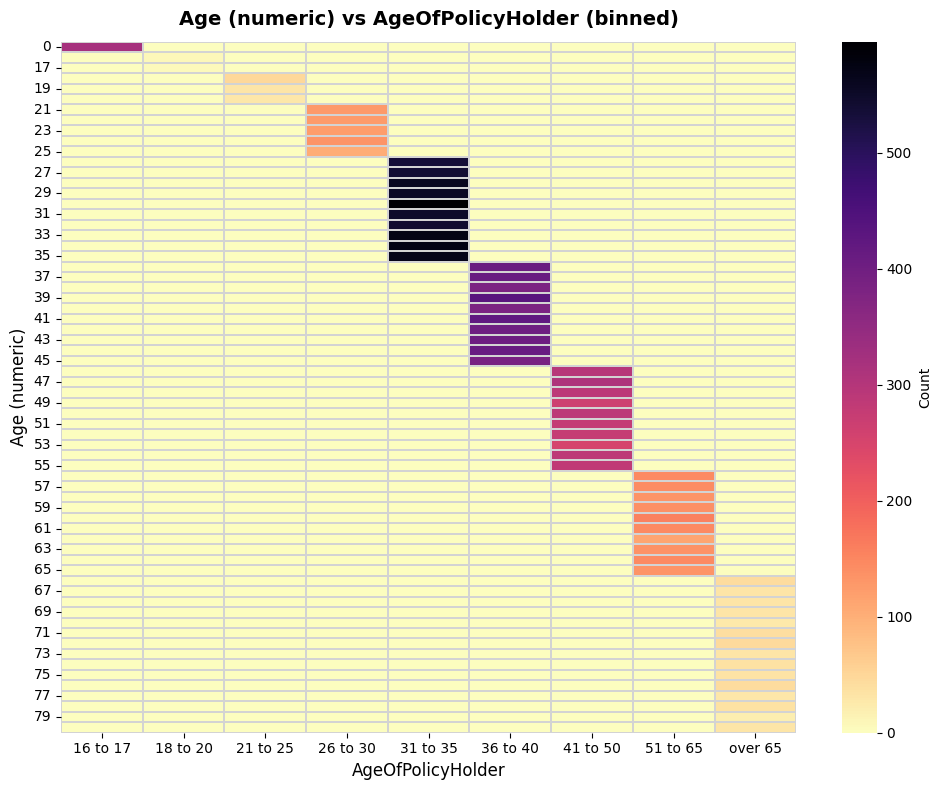

In [29]:
# check Age vs Age of policy holder is it consistent??
# it looks like bins are systemically shifted by one step!

ct = pd.crosstab(df["Age"], df["AgeOfPolicyHolder"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    ct,
    cmap="magma_r",         
    norm=None,               
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Count"}
)

plt.title("Age (numeric) vs AgeOfPolicyHolder (binned)", fontsize=14, weight="bold", pad=12)
plt.xlabel("AgeOfPolicyHolder", fontsize=12)
plt.ylabel("Age (numeric)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
df_raw = df.copy()

mask_bad_claim_date = (df["MonthClaimed"].astype(str) == "0") | (df["DayOfWeekClaimed"].astype(str) == "0")
df = df.loc[~mask_bad_claim_date].copy()

print("Dropped rows:", mask_bad_claim_date.sum())
print("New shape:", df.shape)

Dropped rows: 1
New shape: (15419, 35)


In [31]:
(df["Age"].eq(0)
 .groupby(df["AgeOfPolicyHolder"])
 .agg(["mean", "sum", "count"])
 .sort_values("mean", ascending=False))

,mean,sum,count
AgeOfPolicyHolder,,,
16 to 17,1.0,319,319
18 to 20,0.0,0,15
21 to 25,0.0,0,108
26 to 30,0.0,0,613
31 to 35,0.0,0,5593
36 to 40,0.0,0,4043
41 to 50,0.0,0,2828
51 to 65,0.0,0,1392
over 65,0.0,0,508


### Age vs AgeOfPolicyHolder consistency check

We observed that `Age == 0` occurs in 320 rows. A cross-tabulation shows that **all** `Age == 0` cases belong to `AgeOfPolicyHolder = "16 to 17"`, and **every** row in `"16 to 17"` has `Age == 0`. 

This indicates that `Age` is not reliably recorded for that age band and likely contains a systematic coded/invalid value. Therefore, `AgeOfPolicyHolder` appears to be the more consistent representation of age, while `Age` requires special handling (e.g., treating `Age==0` as missing or relying on the binned feature).
most likely due to privacy policy/prevention of exact ages for minors, or data source/extraction restrictions

For minors, exact age is not available but based on a shifted ahe in bins in `AgeofPolicyHolder` we will rely on `Age` and will decide how to trat Age==0 during Feature Engineering. From what we can observe now it looks like Age==0 is coded age for `under 16` so we may design a special flag for this.

In [32]:
# to see if “16–17” is a special target group:

df.groupby("AgeOfPolicyHolder")["FraudFound_P"].agg(["mean","count"]).sort_values("mean", ascending=False)

,mean,count
AgeOfPolicyHolder,,
21 to 25,0.148148,108
18 to 20,0.133333,15
16 to 17,0.097179,319
31 to 35,0.064366,5593
over 65,0.059055,508
36 to 40,0.058620,4043
26 to 30,0.053834,613
41 to 50,0.050919,2828
51 to 65,0.050287,1392


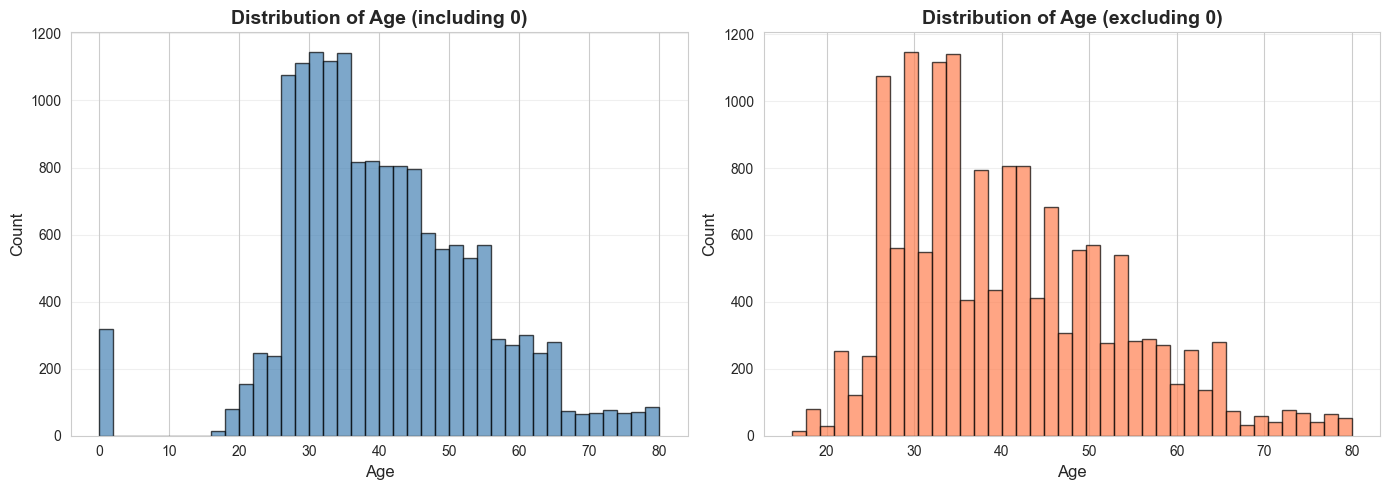

In [33]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age histogram (including 0)
axes[0].hist(df["Age"], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title("Distribution of Age (including 0)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Age", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Age histogram (excluding 0)
axes[1].hist(df.loc[df["Age"] > 0, "Age"], bins=40, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title("Distribution of Age (excluding 0)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Age", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
df.groupby(df["Age"].eq(0))["FraudFound_P"].agg(["mean","count"])

,mean,count
Age,,
False,0.059073,15100
True,0.097179,319


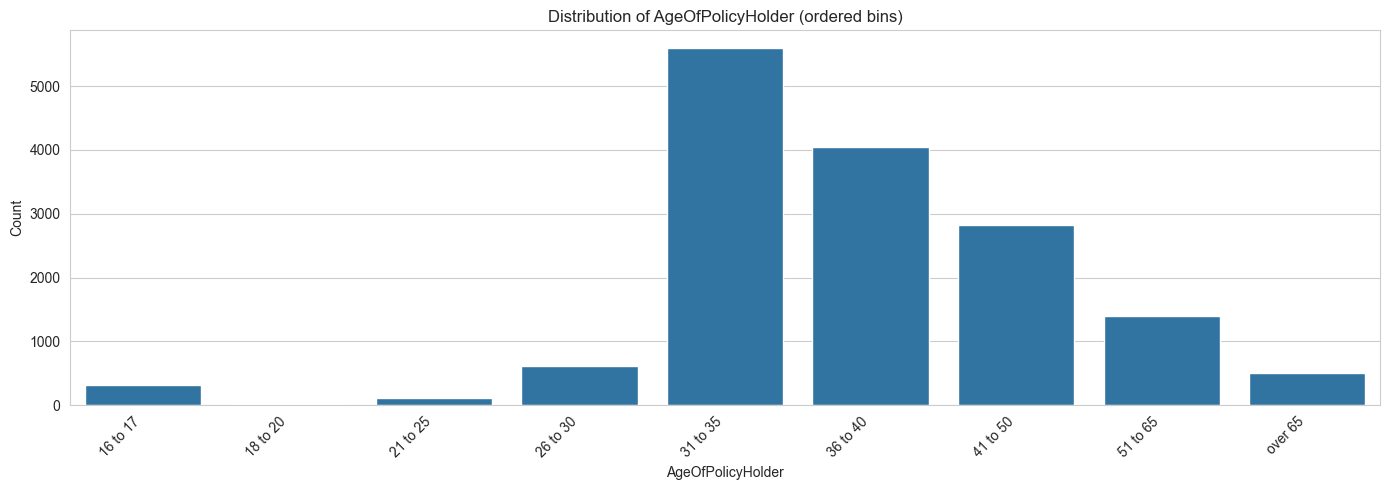

In [35]:
order = ["16 to 17","18 to 20","21 to 25","26 to 30","31 to 35","36 to 40","41 to 50","51 to 65","over 65"]
counts = df["AgeOfPolicyHolder"].value_counts().reindex(order)

plt.figure()
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of AgeOfPolicyHolder (ordered bins)")
plt.xlabel("AgeOfPolicyHolder")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

 **Fraud rate differs by age band (small groups caveat):**  
  Fraud rates are higher in the youngest bins:
  - `21 to 25`: ~0.148 (n=108)
  - `18 to 20`: ~0.133 (n=15)
  - `16 to 17`: ~0.097 (n=320)  
  However, some bins are very small (e.g., `18 to 20`), so these rates should be interpreted cautiously.
Hypothesis: younger policyholders show higher fraud rates, but smallest bins are unstable.

**Implication for later steps:**  
We will treat the above findings as data-quality constraints and decide in the data-cleaning section whether to (a) treat coded values as missing, (b) rely on the binned age feature, and (c) optionally exclude single-row anomalies if needed.

In [36]:
# searching for the “0” token in all object columns

obj_cols = df.select_dtypes(include="object").columns


zero_token_cols = []
for c in obj_cols:
    if (df[c].astype(str) == "0").any():
        zero_token_cols.append(c)

zero_token_cols

[]

In [37]:
# checking for unknown/None etc

suspicious = {"?", "unknown", "Unknown", "none", "None", "NA", "N/A", "null", "Null"}

suspicious_hits = {}
for c in obj_cols:
    vals = set(df[c].astype(str).unique())
    hit = sorted(vals.intersection(suspicious))
    if hit:
        suspicious_hits[c] = hit

suspicious_hits

{'Days_Policy_Accident': ['none'],
 'PastNumberOfClaims': ['none'],
 'NumberOfSuppliments': ['none']}

`none` in `Days_Policy_Accident`, `PastNumberOfClaims` and `NumberOfSuppliments` looks loke valid token; we do not have any other 0 after deletion of suspisious line with corrupted data above

### Univariate Distributions and Fraud Signal (Fraud rate per category)

In [38]:
TARGET = "FraudFound_P"

def cat_summary(df, col, target=TARGET, min_count=50, top_n=None):
    """
    For a categorical column:
    1) prints value counts
    2) prints fraud rate per category + count
    3) plots count barplot
    4) plots fraud-rate barplot (filtered by min_count)
    """
    # tables
    counts = df[col].value_counts(dropna=False)
    if top_n is not None:
        counts = counts.head(top_n)

    rate_tbl = (
        df.groupby(col)[target]
          .agg(fraud_rate="mean", count="size")
          .sort_values("fraud_rate", ascending=False)
    )

    print(f"\n=== {col} ===")
    print("\nCounts:")
    display(counts.to_frame("count"))

    print(f"\nFraud rate by {col} (all categories):")
    display(rate_tbl)

    # plots (counts)
    plt.figure(figsize=(10, 4))
    order_counts = df[col].value_counts().index
    if top_n is not None:
        order_counts = order_counts[:top_n]
    sns.countplot(data=df, x=col, order=order_counts)
    plt.title(f"{col} — distribution (counts)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # plots (fraud rate, filtered)
    filtered = rate_tbl[rate_tbl["count"] >= min_count].copy()
    if filtered.empty:
        print(f"\n[Note] No categories with count >= {min_count} for {col}.")
        return

    plt.figure(figsize=(10, 4))
    sns.barplot(x=filtered.index.astype(str), y=filtered["fraud_rate"].values)
    plt.title(f"{col} — fraud rate (count >= {min_count})")
    plt.ylabel("Fraud rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


=== CoverageType ===

Counts:


,count
CoverageType,
Collision,5962
Liability,5009
All Perils,4448



Fraud rate by CoverageType (all categories):


,fraud_rate,count
CoverageType,,
All Perils,0.101619,4448
Collision,0.072962,5962
Liability,0.007187,5009


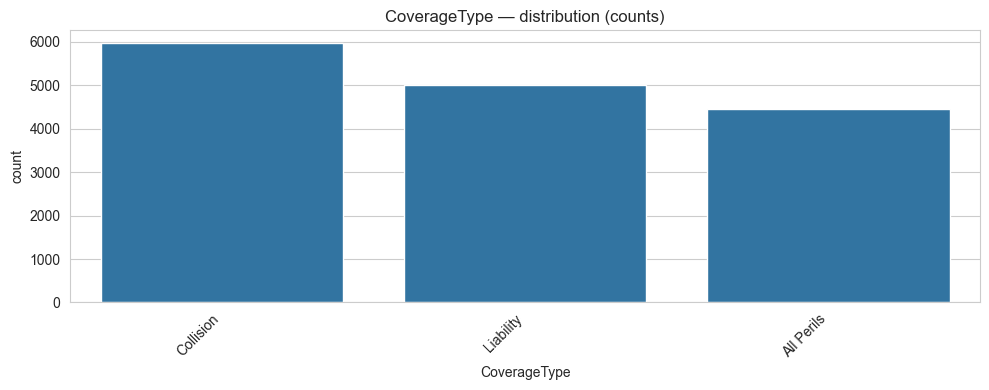

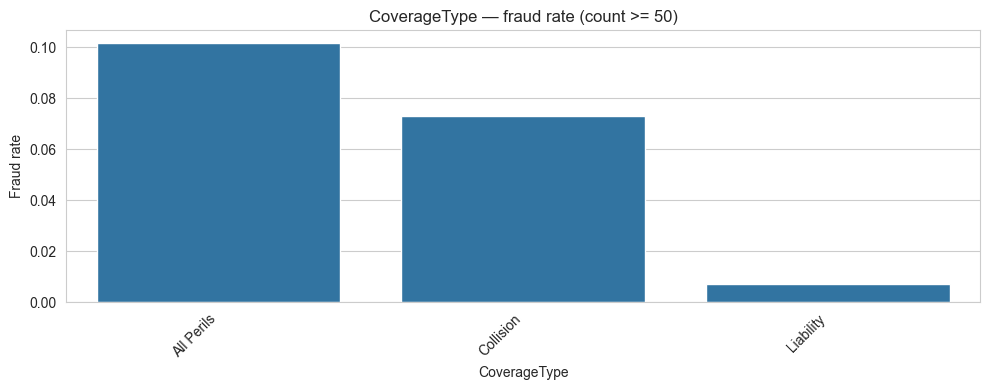


=== VehicleGroup ===

Counts:


,count
VehicleGroup,
Sedan,14657
Utility,391
Sport,371



Fraud rate by VehicleGroup (all categories):


,fraud_rate,count
VehicleGroup,,
Sport,0.129380,371
Utility,0.112532,391
Sedan,0.056696,14657


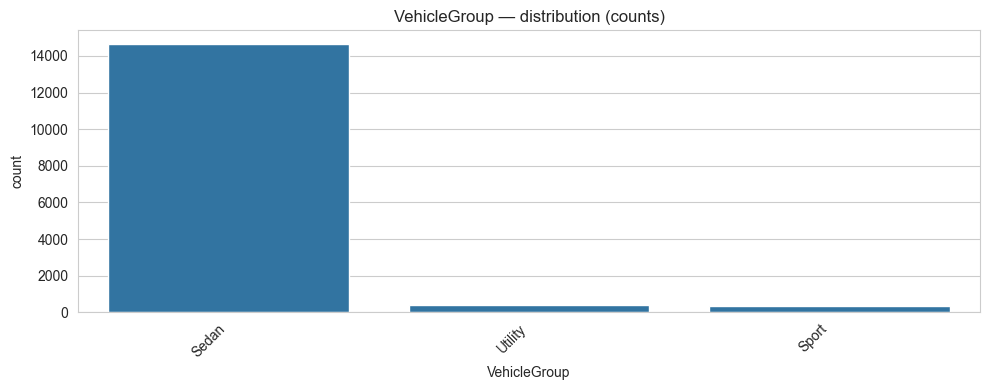

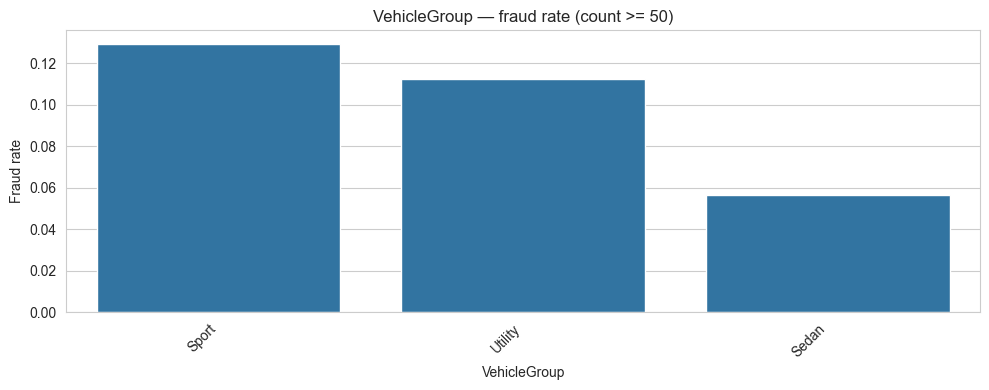


=== BasePolicy ===

Counts:


,count
BasePolicy,
Collision,5962
Liability,5009
All Perils,4448



Fraud rate by BasePolicy (all categories):


,fraud_rate,count
BasePolicy,,
All Perils,0.101619,4448
Collision,0.072962,5962
Liability,0.007187,5009


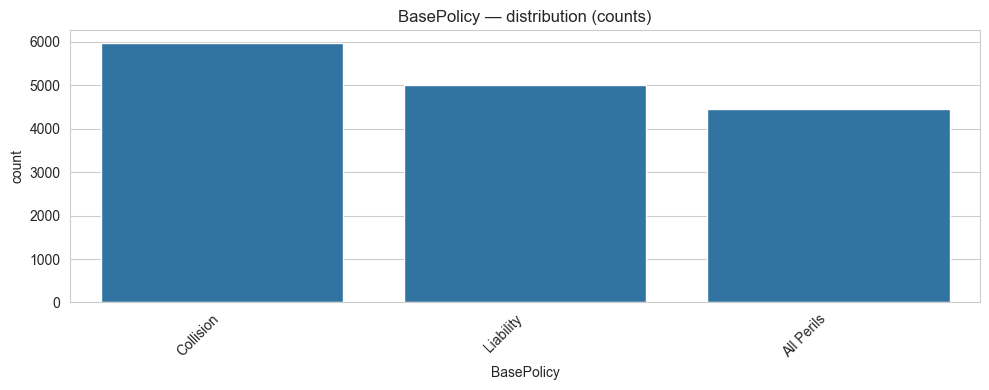

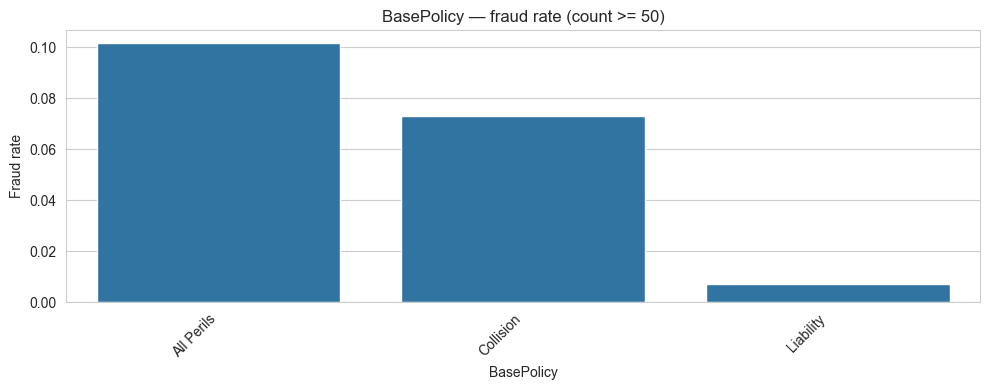


=== VehicleCategory ===

Counts:


,count
VehicleCategory,
Sedan,9670
Sport,5358
Utility,391



Fraud rate by VehicleCategory (all categories):


,fraud_rate,count
VehicleCategory,,
Utility,0.112532,391
Sedan,0.082213,9670
Sport,0.015677,5358


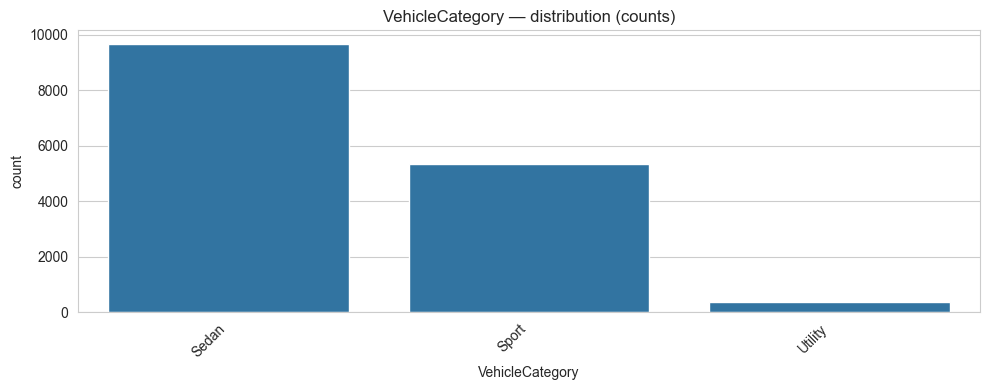

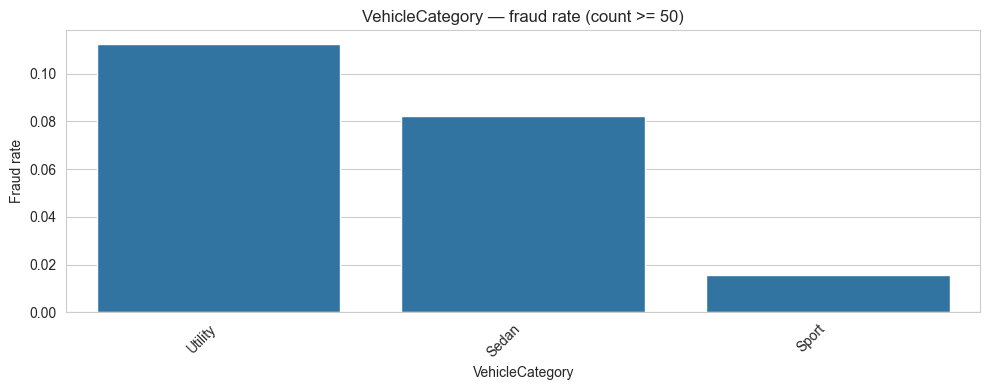


=== VehiclePrice ===

Counts:


,count
VehiclePrice,
20000 to 29000,8079
30000 to 39000,3533
more than 69000,2163
less than 20000,1096
40000 to 59000,461
60000 to 69000,87



Fraud rate by VehiclePrice (all categories):


,fraud_rate,count
VehiclePrice,,
less than 20000,0.093978,1096
more than 69000,0.087379,2163
40000 to 59000,0.067245,461
20000 to 29000,0.052110,8079
30000 to 39000,0.049533,3533
60000 to 69000,0.045977,87


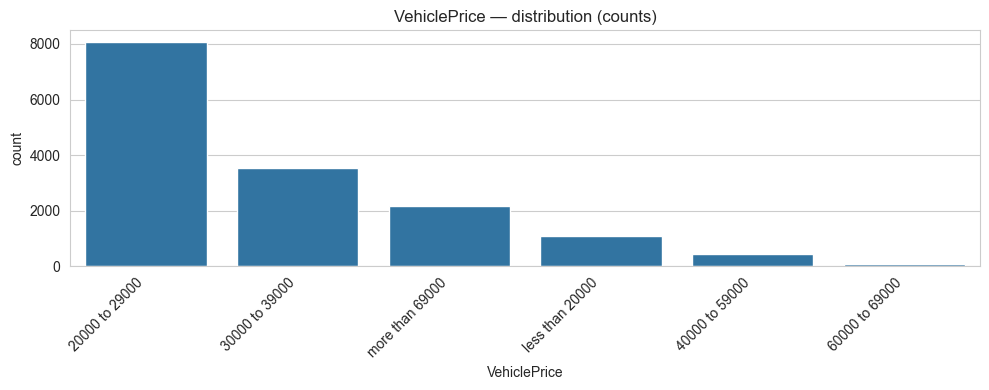

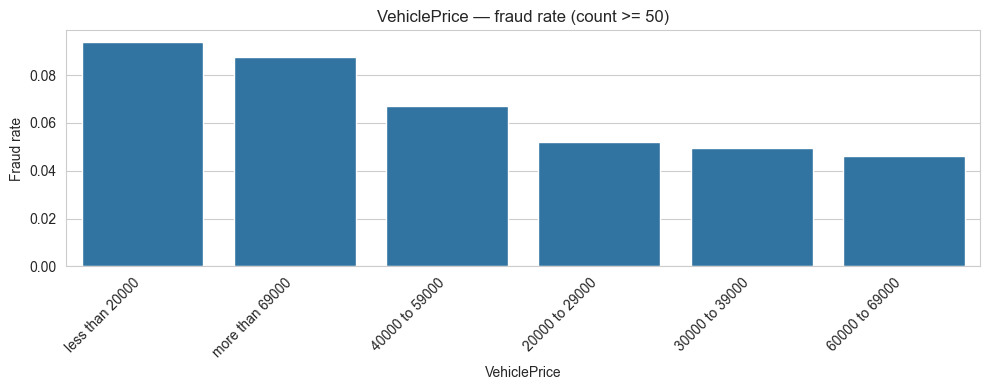


=== AgeOfVehicle ===

Counts:


,count
AgeOfVehicle,
7 years,5807
more than 7,3981
6 years,3448
5 years,1357
new,372
4 years,229
3 years,152
2 years,73



Fraud rate by AgeOfVehicle (all categories):


,fraud_rate,count
AgeOfVehicle,,
4 years,0.091703,229
new,0.086022,372
3 years,0.085526,152
5 years,0.070007,1357
6 years,0.066125,3448
7 years,0.055967,5807
more than 7,0.051746,3981
2 years,0.041096,73


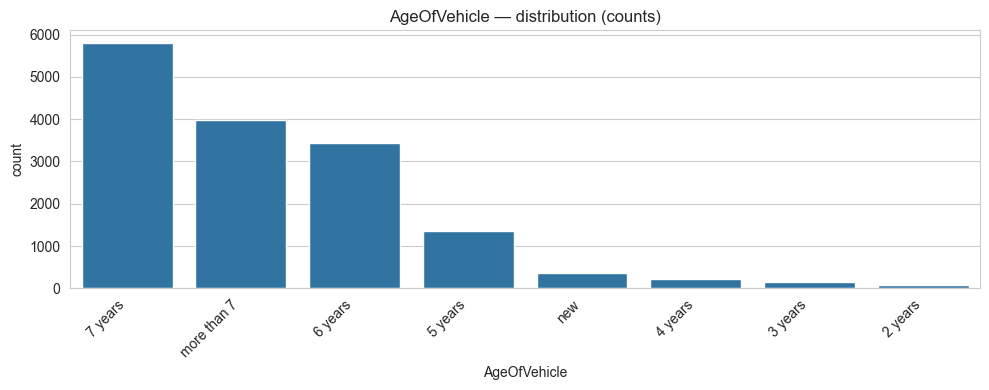

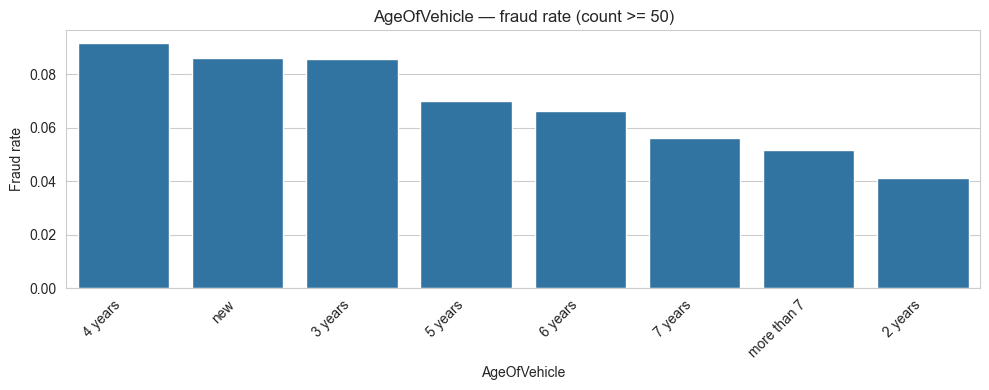


=== AgeOfPolicyHolder ===

Counts:


,count
AgeOfPolicyHolder,
31 to 35,5593
36 to 40,4043
41 to 50,2828
51 to 65,1392
26 to 30,613
over 65,508
16 to 17,319
21 to 25,108
18 to 20,15



Fraud rate by AgeOfPolicyHolder (all categories):


,fraud_rate,count
AgeOfPolicyHolder,,
21 to 25,0.148148,108
18 to 20,0.133333,15
16 to 17,0.097179,319
31 to 35,0.064366,5593
over 65,0.059055,508
36 to 40,0.058620,4043
26 to 30,0.053834,613
41 to 50,0.050919,2828
51 to 65,0.050287,1392


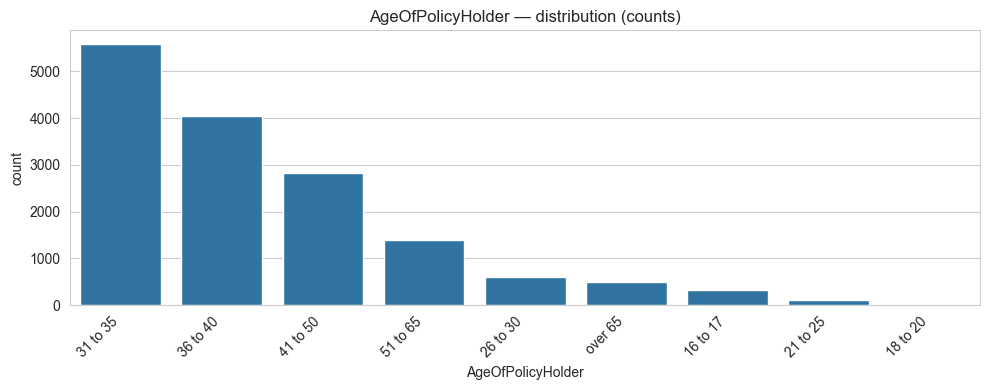

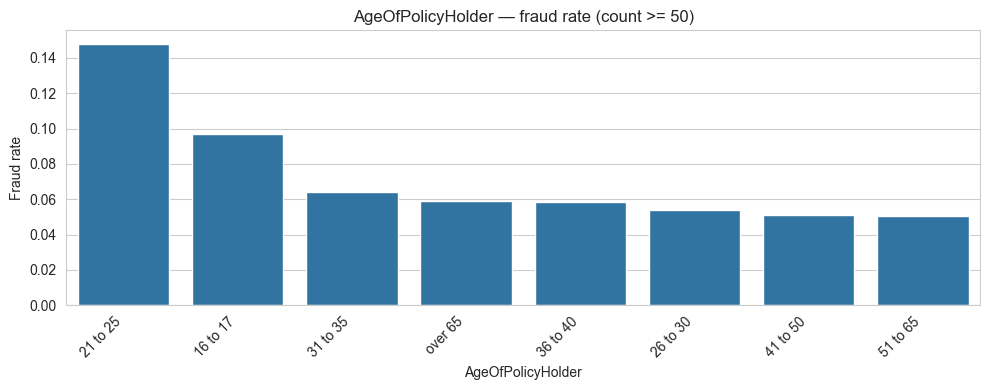


=== PastNumberOfClaims ===

Counts:


,count
PastNumberOfClaims,
2 to 4,5485
none,4351
1,3573
more than 4,2010



Fraud rate by PastNumberOfClaims (all categories):


,fraud_rate,count
PastNumberOfClaims,,
none,0.077913,4351
1,0.062133,3573
2 to 4,0.053601,5485
more than 4,0.033831,2010


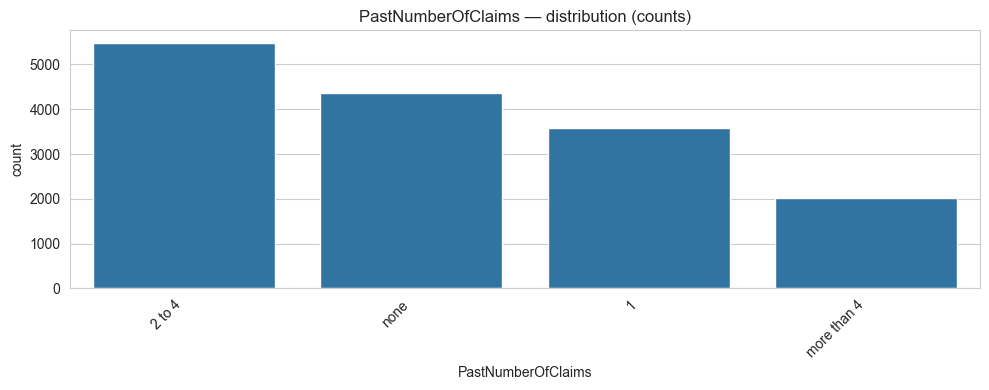

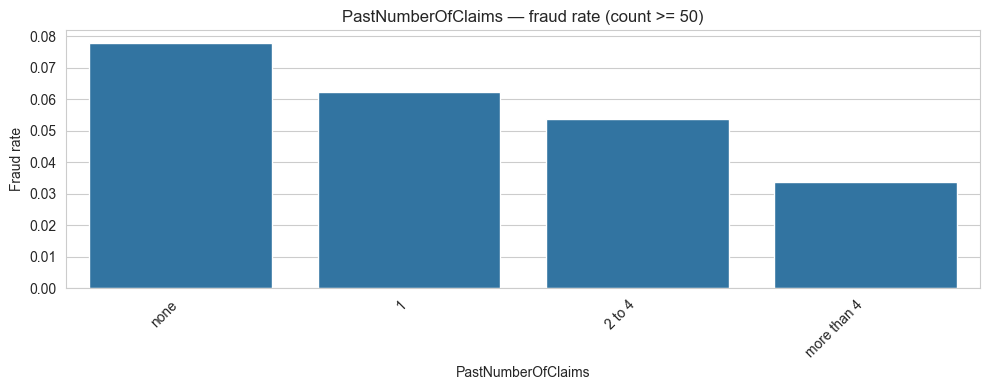


=== NumberOfCars ===

Counts:


,count
NumberOfCars,
1 vehicle,14315
2 vehicles,709
3 to 4,372
5 to 8,21
more than 8,2



Fraud rate by NumberOfCars (all categories):


,fraud_rate,count
NumberOfCars,,
3 to 4,0.077957,372
2 vehicles,0.060649,709
1 vehicle,0.059378,14315
5 to 8,0.047619,21
more than 8,0.000000,2


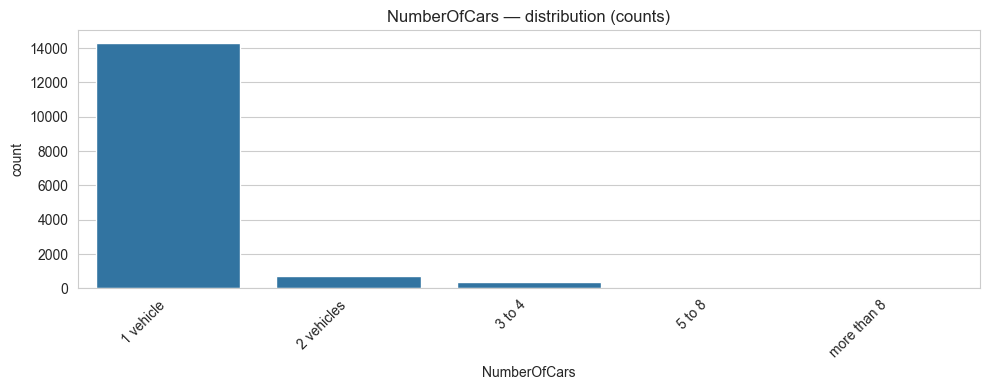

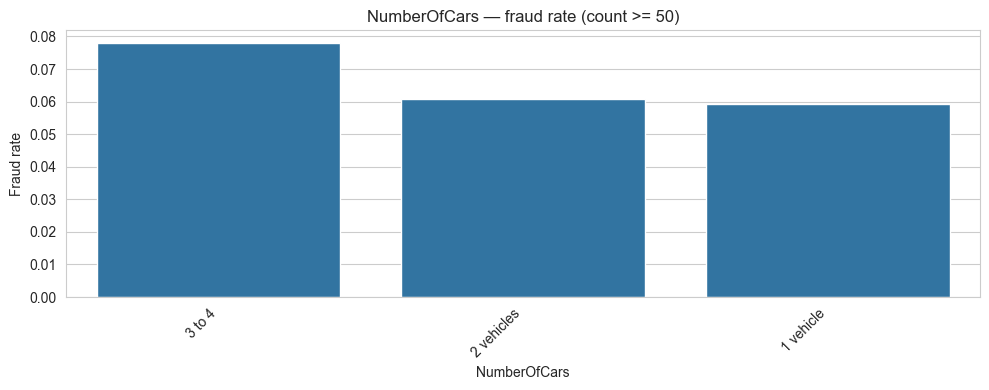


=== AddressChange_Claim ===

Counts:


,count
AddressChange_Claim,
no change,14323
4 to 8 years,631
2 to 3 years,291
1 year,170
under 6 months,4



Fraud rate by AddressChange_Claim (all categories):


,fraud_rate,count
AddressChange_Claim,,
under 6 months,0.750000,4
2 to 3 years,0.175258,291
1 year,0.064706,170
no change,0.057600,14323
4 to 8 years,0.052298,631


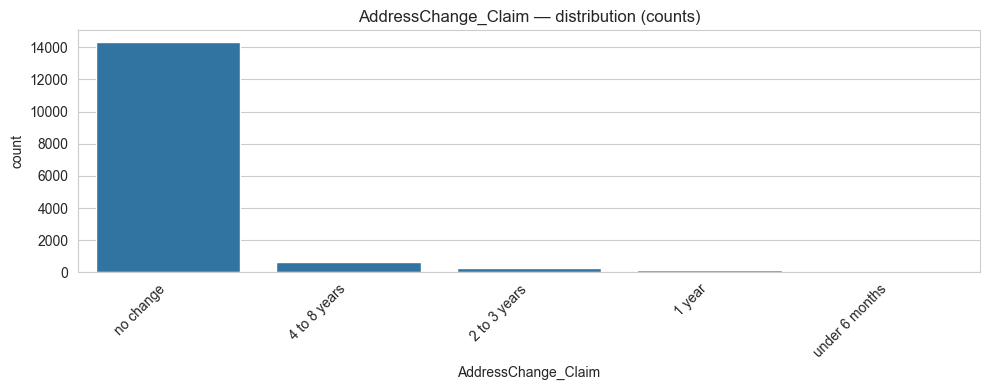

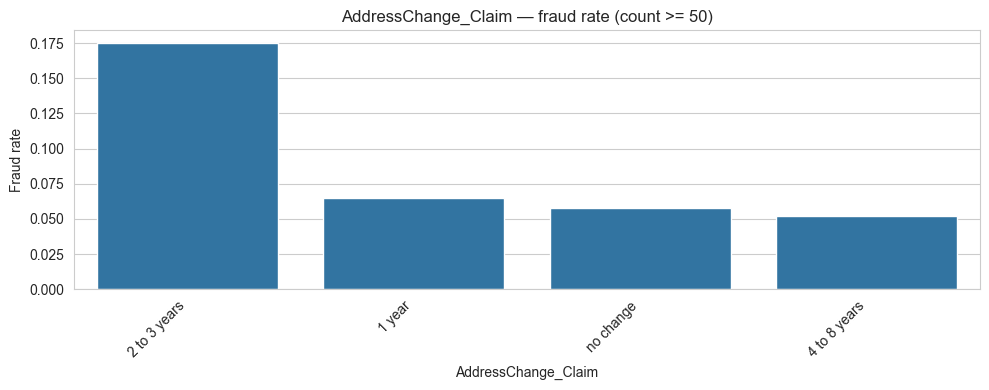


=== AccidentArea ===

Counts:


,count
AccidentArea,
Urban,13822
Rural,1597



Fraud rate by AccidentArea (all categories):


,fraud_rate,count
AccidentArea,,
Rural,0.083281,1597
Urban,0.057155,13822


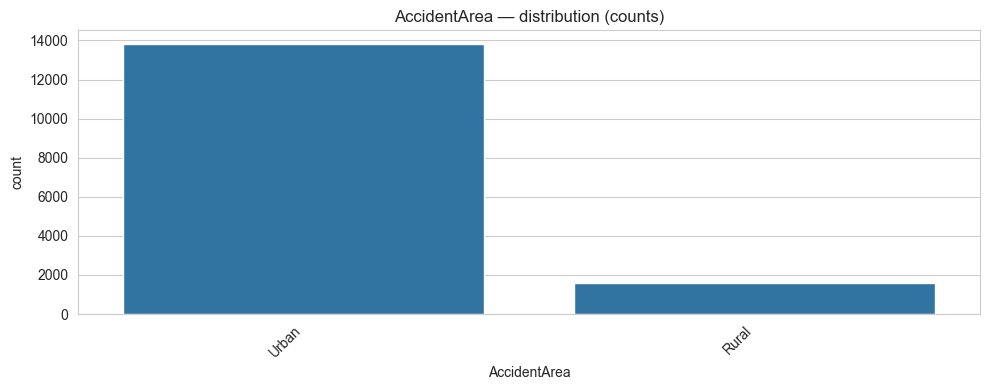

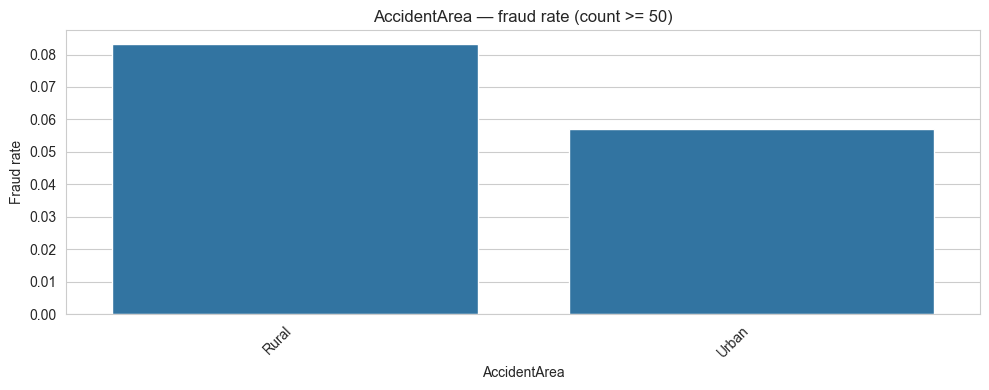


=== Fault ===

Counts:


,count
Fault,
Policy Holder,11229
Third Party,4190



Fraud rate by Fault (all categories):


,fraud_rate,count
Fault,,
Policy Holder,0.078903,11229
Third Party,0.008831,4190


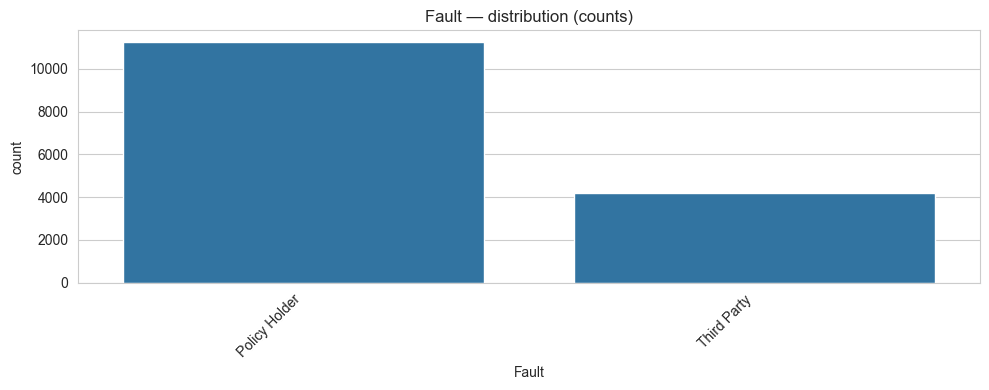

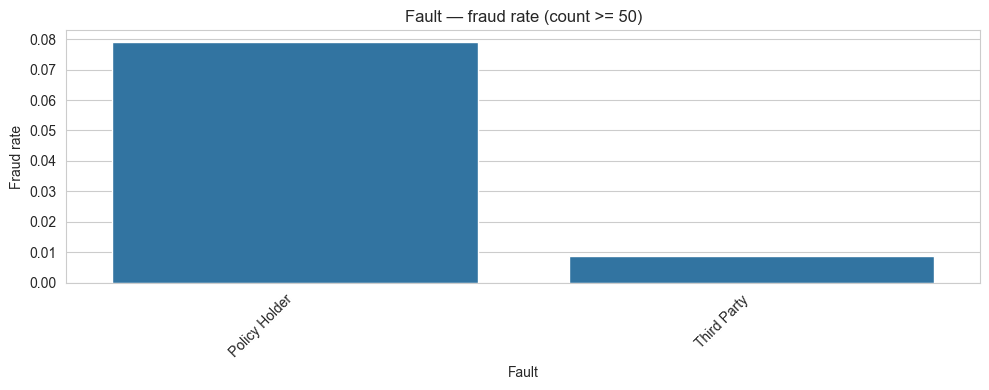


=== PoliceReportFiled ===

Counts:


,count
PoliceReportFiled,
No,14991
Yes,428



Fraud rate by PoliceReportFiled (all categories):


,fraud_rate,count
PoliceReportFiled,,
No,0.060503,14991
Yes,0.037383,428


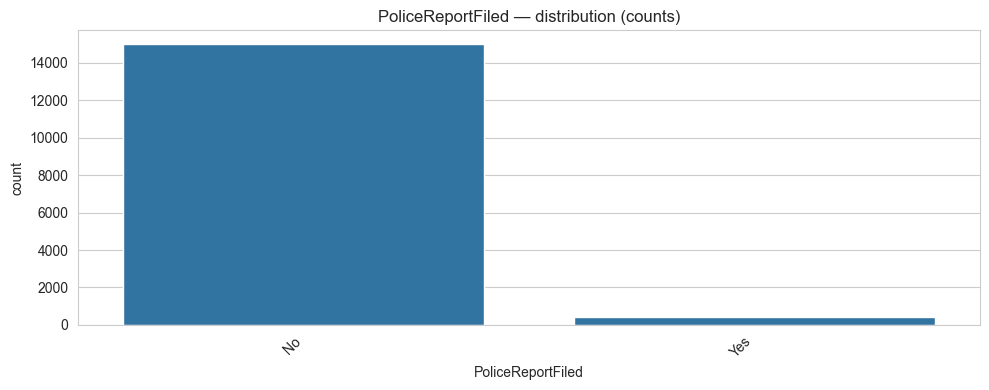

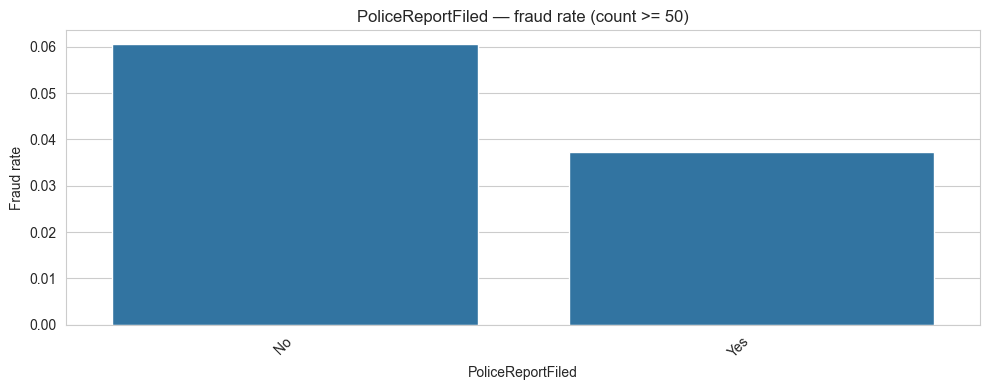


=== WitnessPresent ===

Counts:


,count
WitnessPresent,
No,15332
Yes,87



Fraud rate by WitnessPresent (all categories):


,fraud_rate,count
WitnessPresent,,
No,0.060005,15332
Yes,0.034483,87


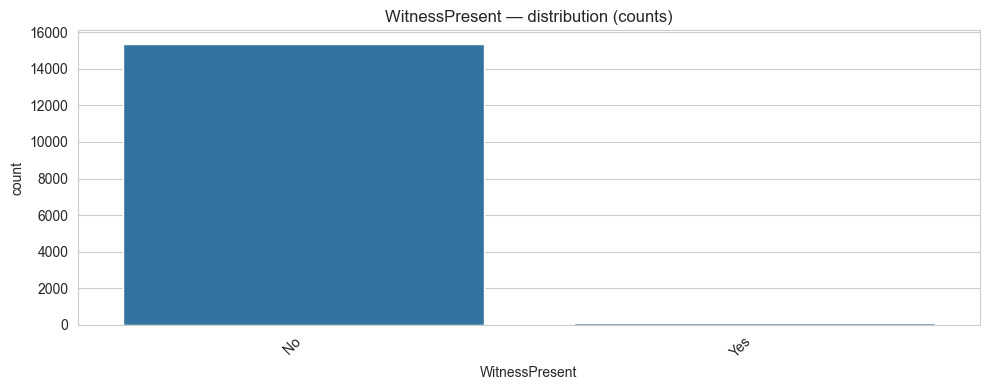

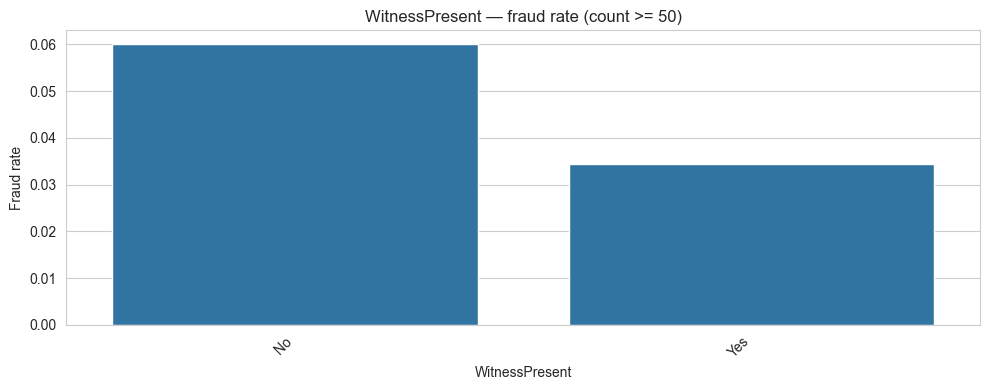


=== AgentType ===

Counts:


,count
AgentType,
External,15178
Internal,241



Fraud rate by AgentType (all categories):


,fraud_rate,count
AgentType,,
External,0.060548,15178
Internal,0.016598,241


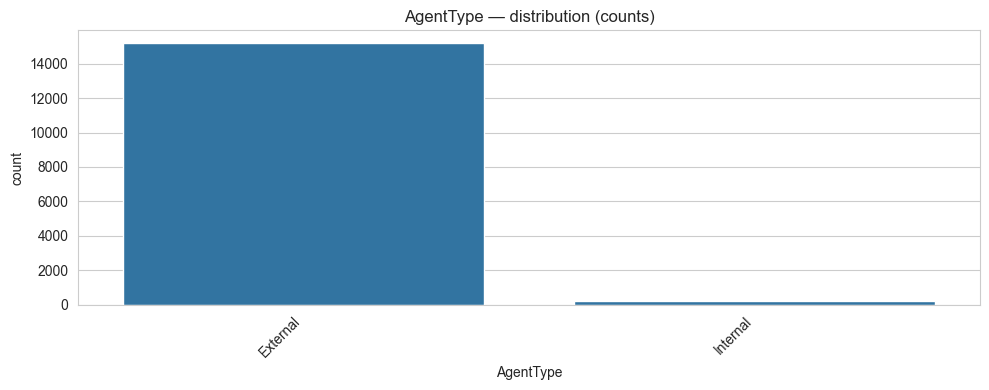

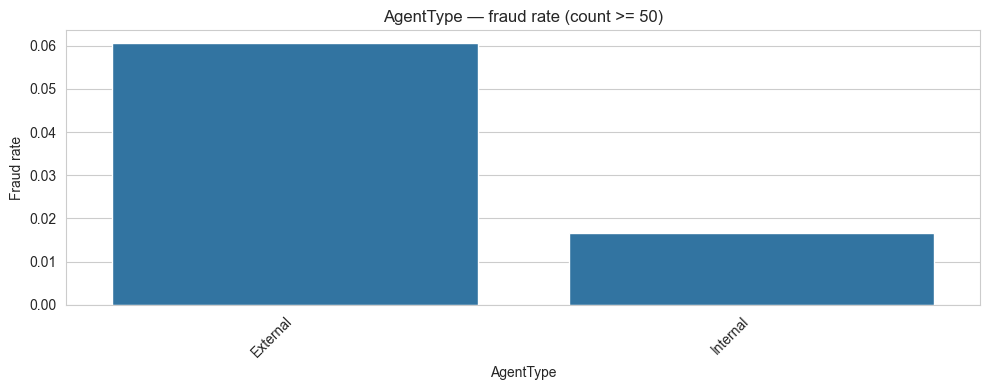


=== NumberOfSuppliments ===

Counts:


,count
NumberOfSuppliments,
none,7046
more than 5,3867
1 to 2,2489
3 to 5,2017



Fraud rate by NumberOfSuppliments (all categories):


,fraud_rate,count
NumberOfSuppliments,,
none,0.066988,7046
1 to 2,0.063881,2489
more than 5,0.050427,3867
3 to 5,0.048091,2017


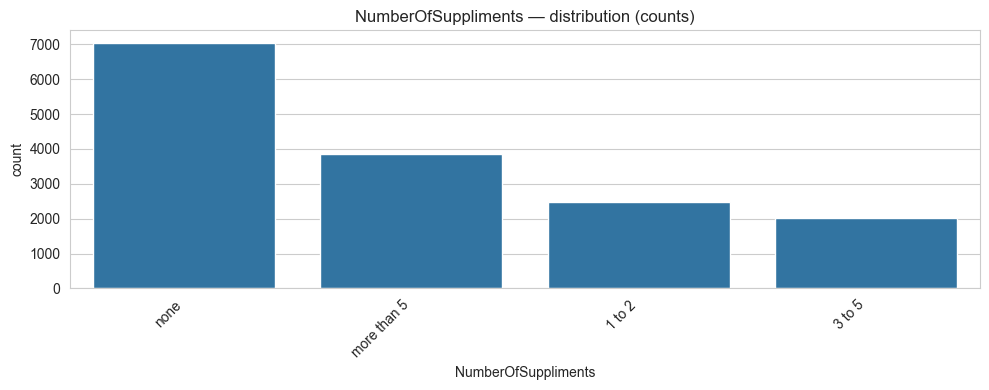

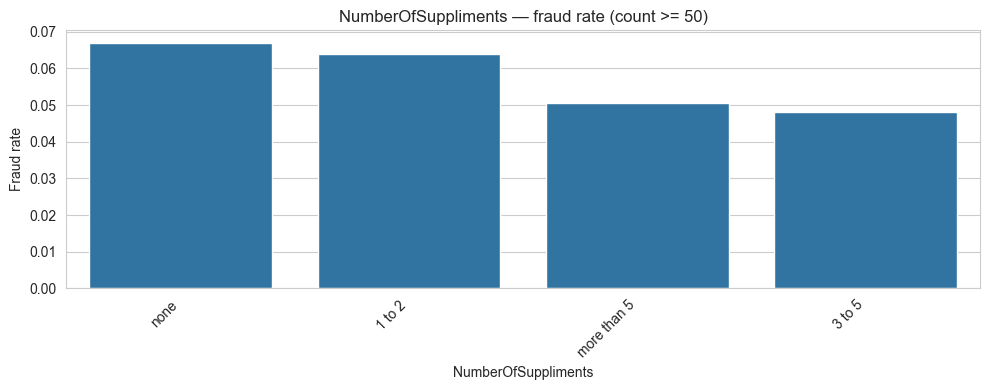

In [39]:
eda_cols = [
    "CoverageType", "VehicleGroup", "BasePolicy", "VehicleCategory",
    "VehiclePrice", "AgeOfVehicle",
    "AgeOfPolicyHolder", "PastNumberOfClaims", "NumberOfCars", "AddressChange_Claim",
    "AccidentArea", "Fault", "PoliceReportFiled", "WitnessPresent",
    "AgentType", "NumberOfSuppliments"
]

for c in eda_cols:
    cat_summary(df, c, min_count=50)

In [40]:
# it looks like CoverageType and BasePolicy are duplicate feature, we have to check!

(df["BasePolicy"] == df["CoverageType"]).mean()

np.float64(1.0)

**Decision:** Drop `BasePolicy` (duplicate of `CoverageType`).  
**Evidence:** `mean(BasePolicy == CoverageType) = 1.0`.  
**Rationale:** avoid redundant features and double-counting the same signal.

In [41]:
# why VehicleGroup (from PolicyType) does NOT match VehicleCategory?
# VehicleCategory: Sport 5358, Sedan 9670, Utility 391
# VehicleGroup (from PolicyType): Sedan 14657, Sport 371, Utility 391

pd.crosstab(df["VehicleCategory"], df["VehicleGroup"], normalize="index")

VehicleGroup,Sedan,Sport,Utility
VehicleCategory,,,
Sedan,1.000000,0.000000,0.0
Sport,0.930758,0.069242,0.0
Utility,0.000000,0.000000,1.0


In [42]:
tmp = df[df["VehicleCategory"] == "Sport"].groupby("VehicleGroup")["FraudFound_P"].agg(["mean","count"])
tmp

,mean,count
VehicleGroup,,
Sedan,0.007219,4987
Sport,0.129380,371


In [43]:
df[df["VehicleCategory"] == "Sport"].groupby("VehicleGroup")["FraudFound_P"].agg(["mean","count"])

,mean,count
VehicleGroup,,
Sedan,0.007219,4987
Sport,0.129380,371


In [44]:
pair_stats = (
    df.groupby(["VehicleCategory", "VehicleGroup"])["FraudFound_P"]
      .agg(fraud_rate="mean", count="size")
      .sort_values(["fraud_rate", "count"], ascending=[False, False])
)
pair_stats

,,fraud_rate,count
VehicleCategory,VehicleGroup,,
Sport,Sport,0.129380,371
Utility,Utility,0.112532,391
Sedan,Sedan,0.082213,9670
Sport,Sedan,0.007219,4987


In [45]:
pd.crosstab(df["VehicleGroup"], df["CoverageType"], normalize="index")
pd.crosstab(df["VehicleGroup"], df["CoverageType"])

CoverageType,All Perils,Collision,Liability
VehicleGroup,,,
Sedan,4086,5584,4987
Sport,22,348,1
Utility,340,30,21


In [46]:
# let's create a feature for mismatch between sport and sedan to understand this data more: it might be a signal/proxy for policies/possible bias? 
# does people with sport cat buy 'sedan insurace'? is it different policy type or different agents naming? 
# we will deside should we use it for model below

df["sport_sedan_mismatch"] = (df["VehicleCategory"] == "Sport") & (df["VehicleGroup"] == "Sedan")

df.groupby("sport_sedan_mismatch")["FraudFound_P"].agg(["mean", "count"])

,mean,count
sport_sedan_mismatch,,
False,0.085027,10432
True,0.007219,4987


In [47]:
# it is unusual that PastNumberOfClaims makes Fraud rate nigher from none past climes, lower from more than 4 past climes

pd.crosstab(df["PastNumberOfClaims"], df["CoverageType"], normalize="index")

CoverageType,All Perils,Collision,Liability
PastNumberOfClaims,,,
1,0.340610,0.434929,0.224461
2 to 4,0.211486,0.369736,0.418778
more than 4,0.123383,0.222886,0.653731
none,0.418984,0.444036,0.136980


In [48]:
df.groupby(["CoverageType","PastNumberOfClaims"])["FraudFound_P"].agg(["mean","count"]).sort_values(["CoverageType","mean"], ascending=[True, False])

mean  count
CoverageType PastNumberOfClaims                 
All Perils   2 to 4              0.105172   1160
             1                   0.102712   1217
             none                0.100384   1823
             more than 4         0.088710    248
Collision    more than 4         0.082589    448
             none                0.077122   1932
             2 to 4              0.076430   2028
             1                   0.060489   1554
Liability    none                0.011745    596
             2 to 4              0.007401   2297
             more than 4         0.006849   1314
             1                   0.003741    802

In [49]:
# is Utility category leads to real risk?

pd.crosstab(df["VehicleCategory"], df["CoverageType"], normalize="index")

CoverageType,All Perils,Collision,Liability
VehicleCategory,,,
Sedan,0.422544,0.577456,0.000000
Sport,0.004106,0.064950,0.930944
Utility,0.869565,0.076726,0.053708


In [50]:
df.groupby(["VehicleCategory","CoverageType"])["FraudFound_P"].agg(["mean","count"])

mean  count
VehicleCategory CoverageType                 
Sedan           All Perils    0.100587   4086
                Collision     0.068768   5584
Sport           All Perils    0.000000     22
                Collision     0.137931    348
                Liability     0.007217   4988
Utility         All Perils    0.120588    340
                Collision     0.100000     30
                Liability     0.000000     21

### Univariate Distributions and Fraud Signal Overview


#### Duplicate / redundant feature detected: `BasePolicy` == `CoverageType`

During EDA we created `CoverageType` by splitting `PolicyType` into two interpretable components:
- `VehicleGroup` (Sedan / Sport / Utility)
- `CoverageType` (Collision / Liability / All Perils)

We then verified that the existing feature `BasePolicy` is an exact duplicate of `CoverageType`

**Decision:** drop `BasePolicy` to avoid redundancy and double-counting the same signal during modelling.

#### `VehicleCategory` vs `VehicleGroup`: different concepts (vehicle class vs policy product grouping)

Initial plots suggested “strange” behaviour for Sport and Utility categories. To understand it, we tested the relationship between:
- `VehicleCategory` (the vehicle class recorded in the dataset: Sedan / Sport / Utility)
- `VehicleGroup` (derived from `PolicyType`: Sedan / Sport / Utility)

Cross-tabs show that these two features are not interchangeable:

- For Sedan and Utility, mapping is consistent.
- For Sport, most vehicles labelled `Sport` in `VehicleCategory` appear as `Sedan` in `VehicleGroup`.

To interpret this correctly, we examined `VehicleGroup` against `CoverageType`:

- Evidence (counts by `VehicleGroup × CoverageType`):
  - `VehicleGroup = Sport` is almost entirely **Collision** (348/371), with a small **All Perils** segment (22/371).
  - `VehicleGroup = Utility` is mostly **All Perils** (340/391).
  - `VehicleGroup = Sedan` contains a mixed distribution of coverages.

**Interpretation (working assumption):**
- `VehicleCategory` likely represents the physical vehicle class.
- `VehicleGroup` behaves like a **policy product grouping** (a packaging/label associated with `PolicyType`), strongly linked to the coverage mix rather than the physical class.

**Decision:** do not “correct” mismatches between `VehicleCategory` and `VehicleGroup`. We keep both as distinct signals and will consider interaction effects in modelling.


#### Why Utility shows a high fraud rate?

Utility appeared high-risk in the initial univariate fraud rate view. We checked whether this is an independent Utility effect or mostly a coverage composition effect.

- Evidence: Utility policies are overwhelmingly **All Perils** (`~87%` of Utility rows).
- Fraud rate within coverage:
  - Utility + All Perils: ~12% (n≈340)
  - Sedan + All Perils: ~10% (n≈4086)

**Hypothesis:**
Utility’s overall high fraud rate is largely explained by its strong association with the higher-risk coverage mix (All Perils). There may be an additional Utility effect, but it is smaller and should be treated cautiously due to the smaller sample size.

**Decision:** keep Utility categories, but interpret their fraud signal in the context of `CoverageType`. We will rely on model-based validation (with interactions) rather than standalone conclusions.


#### Practical modelling implications (what this changes downstream)

From these checks we derive several modelling actions:

- **Drop redundant features:** remove `BasePolicy` (exact duplicate of `CoverageType`).
- **Keep distinct concepts:** retain both `VehicleCategory` (vehicle class) and `VehicleGroup` (policy product grouping).
- **Consider interaction features:** the fraud signal depends on combinations (e.g., vehicle class × coverage type), so interaction terms may be informative (to be tested during modelling / ablation).
- **Avoid premature “data error fixes”:** observed mismatches appear systematic and tied to policy structure, not random noise. We therefore avoid manual “corrections” that could destroy real patterns.

Next, we continue EDA with other categorical variables and explicitly assess which features may reflect post-claim processes (potential leakage), such as `NumberOfSuppliments`, `PoliceReportFiled`, and `WitnessPresent`.

In [51]:
# Drop exact duplicate feature

assert (df["BasePolicy"] == df["CoverageType"]).all(), "BasePolicy is not an exact duplicate of CoverageType"
df = df.drop(columns=["BasePolicy"])

### Process features analysis

In [52]:
# a function to quickly run categorical features equally

def cat_fraud_table(df, col, target="FraudFound_P", min_count=50):
    out = (
        df.groupby(col)[target]
          .agg(fraud_rate="mean", count="size")
          .sort_values(["fraud_rate", "count"], ascending=[False, False])
    )
    out_filtered = out[out["count"] >= min_count]
    return out, out_filtered

process_cols = [
    "NumberOfSuppliments",
    "PoliceReportFiled",
    "WitnessPresent",
    "AgentType",
    "Fault",
    "Days_Policy_Accident",
    "Days_Policy_Claim",
]

for c in process_cols:
    full, filt = cat_fraud_table(df, c, min_count=50)
    print(f"\n=== {c} (all categories) ===")
    display(full)
    print(f"\n=== {c} (count >= 50) ===")
    display(filt)


=== NumberOfSuppliments (all categories) ===


,fraud_rate,count
NumberOfSuppliments,,
none,0.066988,7046
1 to 2,0.063881,2489
more than 5,0.050427,3867
3 to 5,0.048091,2017



=== NumberOfSuppliments (count >= 50) ===


,fraud_rate,count
NumberOfSuppliments,,
none,0.066988,7046
1 to 2,0.063881,2489
more than 5,0.050427,3867
3 to 5,0.048091,2017



=== PoliceReportFiled (all categories) ===


,fraud_rate,count
PoliceReportFiled,,
No,0.060503,14991
Yes,0.037383,428



=== PoliceReportFiled (count >= 50) ===


,fraud_rate,count
PoliceReportFiled,,
No,0.060503,14991
Yes,0.037383,428



=== WitnessPresent (all categories) ===


,fraud_rate,count
WitnessPresent,,
No,0.060005,15332
Yes,0.034483,87



=== WitnessPresent (count >= 50) ===


,fraud_rate,count
WitnessPresent,,
No,0.060005,15332
Yes,0.034483,87



=== AgentType (all categories) ===


,fraud_rate,count
AgentType,,
External,0.060548,15178
Internal,0.016598,241



=== AgentType (count >= 50) ===


,fraud_rate,count
AgentType,,
External,0.060548,15178
Internal,0.016598,241



=== Fault (all categories) ===


,fraud_rate,count
Fault,,
Policy Holder,0.078903,11229
Third Party,0.008831,4190



=== Fault (count >= 50) ===


,fraud_rate,count
Fault,,
Policy Holder,0.078903,11229
Third Party,0.008831,4190



=== Days_Policy_Accident (all categories) ===


,fraud_rate,count
Days_Policy_Accident,,
none,0.163636,55
8 to 15,0.090909,55
1 to 7,0.071429,14
15 to 30,0.061224,49
more than 30,0.059360,15246



=== Days_Policy_Accident (count >= 50) ===


,fraud_rate,count
Days_Policy_Accident,,
none,0.163636,55
8 to 15,0.090909,55
more than 30,0.059360,15246



=== Days_Policy_Claim (all categories) ===


,fraud_rate,count
Days_Policy_Claim,,
8 to 15,0.142857,21
15 to 30,0.107143,56
more than 30,0.059575,15342



=== Days_Policy_Claim (count >= 50) ===


,fraud_rate,count
Days_Policy_Claim,,
15 to 30,0.107143,56
more than 30,0.059575,15342


Observatrion:

**Strongest univariate separation**
- **`Fault`** shows a very large difference: `Policy Holder` has a much higher fraud rate (~7.9%) than `Third Party` (~0.9%).  
  This is a strong signal, but its interpretation depends on when fault is determined - self-reported at FNOL vs confirmed during investigation.

**Operational / process proxy patterns**
- **`AgentType`** differs sharply: `External` (~6.1%) vs `Internal` (~1.7%), with `Internal` being a small minority group.  
  This suggests `AgentType` may capture operational workflow/channel differences, not only claimant behaviour.

**Post-claim / handling indicators (weaker or ambiguous patterns)**
- **`NumberOfSuppliments`** does not increase fraud risk monotonically; categories with more supplements show slightly lower fraud rates than `none`.  
  This pattern is consistent with a handling/process variable rather than a direct fraud driver.

**Small-group caution**
- **`PoliceReportFiled`** and **`WitnessPresent`** show lower fraud rates for `Yes` than `No`, but the `Yes` groups are relatively small (especially `WitnessPresent=Yes`).  
  These features may also be recorded/confirmed during handling, so their availability at scoring time is uncertain.
- **`Days_Policy_Accident`** and **`Days_Policy_Claim`** are highly skewed toward `more than 30`, and some higher fraud rates appear in very small buckets (e.g., `none`, `8 to 15`, `15 to 30`).  
  This suggests these may be bucketed/derived fields and should be interpreted cautiously.

**Implication for next steps**
These tables help us (1) identify potentially strong signals and (2) flag features that may depend on the claim handling timeline. We will later validate their usefulness via ablation tests under different scoring assumptions

### Diagnostic signal scan (univariate AUC)

After inspecting category-level fraud rates we run a simple univariate AUC scan as a diagnostic tool.
The goal is not to perform final feature selection, but to:
- rank features by their standalone predictive signal,
- identify unusually strong predictors that may reflect operational/process stages,
- and flag near-zero-signal features early.

All modelling decisions will still be validated via temporal evaluation and ablation tests under two assumptions:
(1) submission-time screening vs (2) during-handling triage.

#### What univariate AUC measures:

For each single feature we train a very simple model and evaluate its ROC-AUC via cross-validation:

- **Model:** logistic regression (with `class_weight="balanced"`)
- **Preprocessing:**
  - numeric features -> median imputation + standard scaling
  - categorical features -> most-frequent imputation + one-hot encoding
- **Score used for ROC-AUC:** the model’s predicted probability `P(FraudFound_P = 1)`
- **CV protocol:** stratified K-fold (diagnostic only)

Interpretation:
- AUC ≈ 0.50 -> the feature alone carries little standalone signal
- AUC farther from 0.50 -> the feature has stronger *rank-order* signal on its own
- Note: AUC does **not** assume linear relationships in raw feature values; it evaluates how well
  the fitted model can separate fraud vs non-fraud **using only that one feature**.

Important caveats:
- This is **not** final feature selection and does not account for multivariate interactions.
- Strong univariate AUC can indicate either a genuine risk signal or an operational/process proxy
  (potential leakage depending on the deployment stage).
- Therefore, any feature flagged here is only a *candidate* for later ablation/leakage analysis
  under our two deployment assumptions: (1) submission-time screening vs (2) during-handling triage.


We do not rely on correlation matrix here because many predictors are **categorical** or **binned/ordinal** because correlation is not well defined for categorical and ordinal/binned features.
Instead, ROC-AUC from a simple one-feature model provides a consistent, model-based diagnostic signal that works for both numeric and categorical predictors.

In [53]:
TARGET = "FraudFound_P"

def univariate_auc(df, feature, target=TARGET, n_splits=5, random_state=42):
    
    """CV AUC for a single feature (works for both numeric and categorical)."""
    
    X = df[[feature]].copy()
    y = df[target].values

    is_num = pd.api.types.is_numeric_dtype(X[feature])

    if is_num:
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])
    else:
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ])

    model = LogisticRegression(max_iter=2000, class_weight="balanced")

    pipe = Pipeline(steps=[
        ("preprocess", pre),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc").mean()
    return auc

results = []
for col in df.columns:
    if col == TARGET:
        continue
    results.append({
        "feature": col,
        "dtype": str(df[col].dtype),
        "n_unique": df[col].nunique(),
        "univariate_auc": univariate_auc(df, col)
    })

auc_table = (pd.DataFrame(results)
             .sort_values("univariate_auc", ascending=False)
             .reset_index(drop=True))

auc_table.head(35)

,feature,dtype,n_unique,univariate_auc
0,PolicyType,object,9,0.690777
1,CoverageType,object,3,0.680242
2,sport_sedan_mismatch,bool,2,0.651258
3,VehicleCategory,object,3,0.640636
4,Fault,object,2,0.623185
5,PastNumberOfClaims,object,4,0.567442
6,VehiclePrice,object,6,0.552798
7,MonthClaimed,object,12,0.539931
8,AgeOfVehicle,object,8,0.536441
9,Make,object,19,0.534954


In [54]:
y = df["FraudFound_P"].astype(int)
x = df["sport_sedan_mismatch"].astype(int)

auc = roc_auc_score(y, x)
auc_inv = roc_auc_score(y, 1 - x)

auc, auc_inv

(0.3487303778948099, 0.6512696221051901)

#### Note on `sport_sedan_mismatch` direction

During consistency checks we found a large mismatch between `VehicleCategory` and `VehicleGroup`
for the "Sport" label. We engineered a boolean diagnostic feature:

`sport_sedan_mismatch = (VehicleCategory == "Sport") AND (VehicleGroup == "Sedan")`.

In this dataset, `sport_sedan_mismatch=True` is associated with **lower** fraud rate
(i.e., it behaves as a protective signal). This is not a problem: our univariate AUC uses a
logistic regression probability score `P(Fraud=1)`, so the model learns the sign automatically.
We keep the original definition because it is easier to interpret and audit.

### Key signals from the scan (top features)

| Feature | Univariate AUC | What it suggests (diagnostic interpretation) | Notes / caveats |
|---|---:|---|---|
| `PolicyType` | 0.6908 | Strong standalone signal; likely captures differences in product/policy mix and associated handling patterns | High signal may reflect product segmentation, not pure behavior |
| `CoverageType` | 0.6802 | Strong signal; coverage choice is highly informative for the label | Later we found `CoverageType` duplicates `BasePolicy` exactly (keep one) |
| `sport_sedan_mismatch` | 0.6513 | Strong signal via **category-pair structure** (`VehicleCategory` × `VehicleGroup`) | Direction can be counter-intuitive: mismatch may correlate with *lower* fraud while a small “Sport/Sport” subgroup correlates with higher fraud |
| `VehicleCategory` | 0.6406 | Vehicle type grouping carries meaningful signal | Likely interacts with policy/coverage structure |
| `Fault` | 0.6232 | Strong association with the fraud label (liability attribution is highly informative) | May reflect reporting / investigation dynamics (not necessarily causal) |
| `PastNumberOfClaims` | 0.5674 | Moderate signal; claim history correlates with label | Interpretation depends on whether label reflects “fraud found/flagged” vs “fraud intent” (detection effects possible) |
| `VehiclePrice` | 0.5528 | Moderate signal; non-linear risk across price bins | Could reflect both true risk and differential scrutiny for high-value cases |
| `MonthClaimed` | 0.5399 | Weak-to-moderate seasonal/process signal | Could reflect operational seasonality rather than behavior |
| `AgeOfVehicle` | 0.5364 | Weak-to-moderate signal; vehicle age pattern | Might interact with price/category |
| `Make` | 0.5350 | Weak-to-moderate signal; manufacturer proxy | 19 categories → watch for overfitting in some models |
| `Age` | 0.5325 | Small standalone signal | `Age==0` has a known systematic coding for minors (handled separately) |
| `AgeOfPolicyHolder` | 0.5315 | Small standalone signal | More consistent than raw `Age` in minors-coded band |

---

### Takeaways (what we conclude from univariate AUC)

- **Product/policy variables** (`PolicyType`, `CoverageType`) have the strongest standalone signal, suggesting that policy structure and coverage choices are highly informative for the insurer-provided label `FraudFound_P`.
- The previously observed **VehicleCategory vs VehicleGroup inconsistency** shows up as a meaningful diagnostic signal via `sport_sedan_mismatch`, which supports investigating this pattern rather than ignoring it.
- Features near **AUC ≈ 0.50** are **not automatically useless**: they may still contribute in multivariate models via interactions, non-linear effects, or shared signal with other variables. Therefore we **do not drop features solely based on this scan**.
- This scan is also helpful to flag **risk-by-design columns**, especially high-cardinality identifiers (e.g., `PolicyNumber`) that can behave like IDs and may not generalize. Such columns will be handled separately in modeling/ablation decisions.

### Stratified check (sanity test for confounding)

After inspecting marginal fraud rates (e.g., `P(fraud | Fault)`), we run **stratified checks** to verify whether the observed gaps remain **within comparable subgroups**.

Why this matters:
- A strong context variable (e.g., `CoverageType`) can change the **base fraud rate**.
- If a feature (e.g., `Fault`) is unevenly distributed across `CoverageType`, the marginal pattern may reflect **group mixing** rather than a true standalone relationship.
- Stratification approximates a conditional view:

  - Marginal effect:  
    **`P(fraud | X)`**
  - Stratified (conditional) effect:  
    **`P(fraud | X, S)`**, where `S` is a stratifier (e.g., `CoverageType`, `AccidentArea`)

This helps us:
- reduce the risk of misleading conclusions due to **confounding**,
- detect potential **Simpson’s paradox** (direction changes after conditioning),
- understand whether a signal is **robust across segments** or only appears in a specific subgroup.

In practice, we compute fraud rates for feature `X` **inside each level of `S`**, and we apply a minimum-count threshold to avoid overinterpreting very small buckets.

In [55]:
TARGET = "FraudFound_P"


def strat_fraud(df, by, strat, min_count=50):
    """
    Fraud-rate table for `by` within `strat` (can be one column or a list of columns).
    Returns: columns = strat cols + [by, fraud_cases, count, fraud_rate]
    """
    strat_cols = [strat] if isinstance(strat, str) else list(strat)
    group_cols = strat_cols + [by]

    out = (df
           .groupby(group_cols, dropna=False)[TARGET]
           .agg(fraud_cases="sum", count="size")
           .reset_index())

    out["fraud_rate"] = out["fraud_cases"] / out["count"]
    return out[out["count"] >= min_count].sort_values(["fraud_rate", "count"], ascending=False)


In [56]:
# visual 

def plot_strat(res, strat_col, by_col, min_count=50, title=None):
    
    r = res[res['count'] >= min_count].copy()
    
    plt.figure(figsize=(10, 5))
    
    sns.barplot(
        data=r,
        x=strat_col,
        y='fraud_rate',
        hue=by_col,
        errorbar=('ci', 95),
        palette='Set2',
        alpha=0.8
    )
    
    plt.ylabel('Fraud rate', fontsize=11)
    plt.title(title or f"{by_col} within {strat_col}", fontsize=13, pad=15)
    plt.legend(title=by_col, framealpha=0.95)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

In [57]:
# Fault within CoverageType

fault_x_cov = strat_fraud(df, by="Fault", strat="CoverageType", min_count=50)
fault_x_cov

,CoverageType,Fault,fraud_cases,count,fraud_rate
0,All Perils,Policy Holder,436,2796,0.155937
2,Collision,Policy Holder,415,4151,0.099976
3,Collision,Third Party,20,1811,0.011044
1,All Perils,Third Party,16,1652,0.009685
4,Liability,Policy Holder,35,4282,0.008174
5,Liability,Third Party,1,727,0.001376


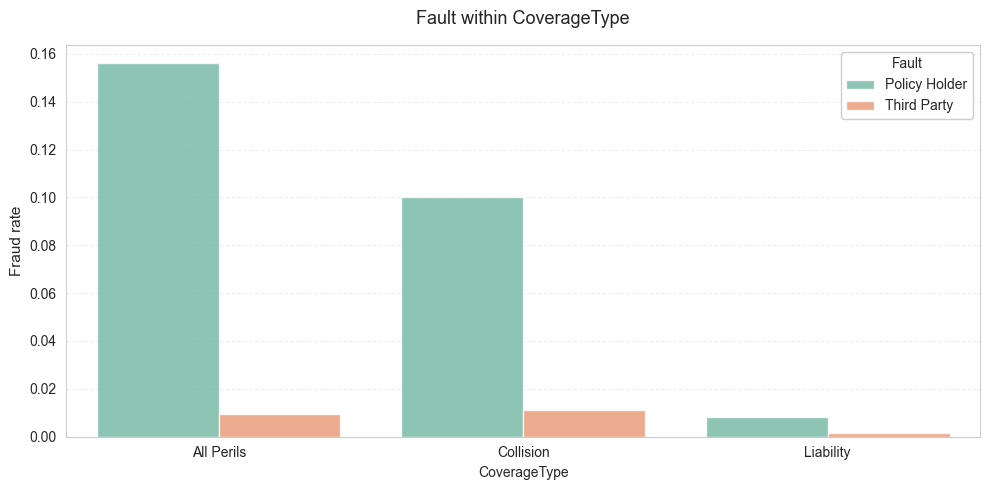

In [58]:
plot_strat(fault_x_cov, "CoverageType", "Fault", 
                  title="Fault within CoverageType")

In [59]:
# AgentType within CoverageType

agent_x_cov = strat_fraud(df, by="AgentType", strat="CoverageType", min_count=50)
agent_x_cov

,CoverageType,AgentType,fraud_cases,count,fraud_rate
0,All Perils,External,452,4448,0.101619
1,Collision,External,431,5849,0.073688
2,Collision,Internal,4,113,0.035398
3,Liability,External,36,4881,0.007376
4,Liability,Internal,0,128,0.000000


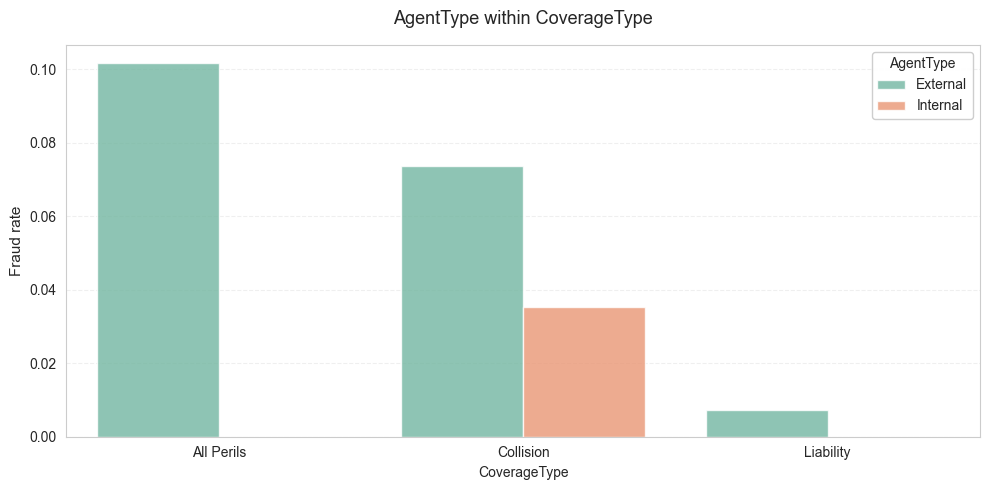

In [60]:
plot_strat(agent_x_cov, "CoverageType", "AgentType", 
                  title="AgentType within CoverageType")

In [61]:
# PoliceReportFiled within AccidentArea

police_x_area = strat_fraud(df, by="PoliceReportFiled", strat="AccidentArea", min_count=50)
police_x_area

,AccidentArea,PoliceReportFiled,fraud_cases,count,fraud_rate
0,Rural,No,132,1554,0.084942
2,Urban,No,775,13437,0.057677
3,Urban,Yes,15,385,0.038961


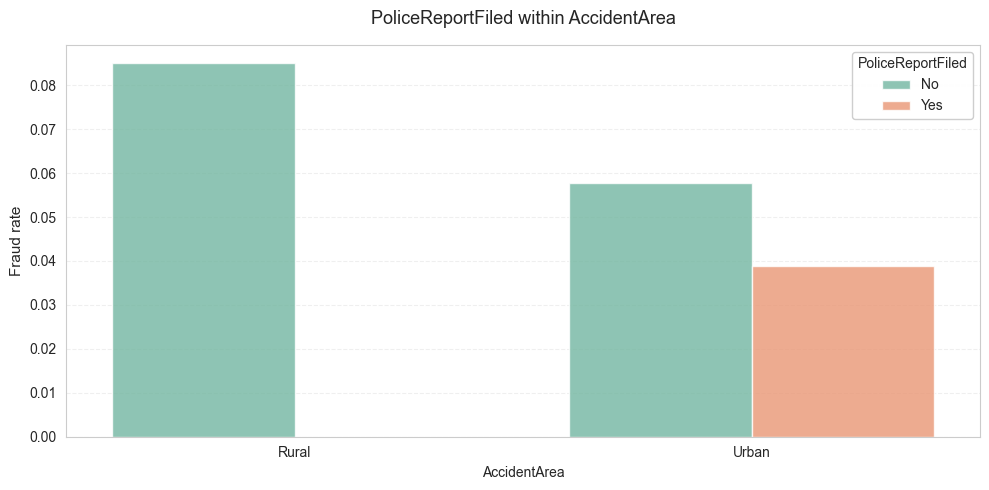

In [62]:
plot_strat(police_x_area, "AccidentArea", "PoliceReportFiled", 
                  title="PoliceReportFiled within AccidentArea")

In [63]:
# PoliceReportFiled within CoverageType

police_x_cov = strat_fraud(df, by="PoliceReportFiled", strat="CoverageType", min_count=50)
police_x_cov

,CoverageType,PoliceReportFiled,fraud_cases,count,fraud_rate
0,All Perils,No,448,4318,0.103752
2,Collision,No,425,5754,0.073862
3,Collision,Yes,10,208,0.048077
1,All Perils,Yes,4,130,0.030769
5,Liability,Yes,2,90,0.022222
4,Liability,No,34,4919,0.006912


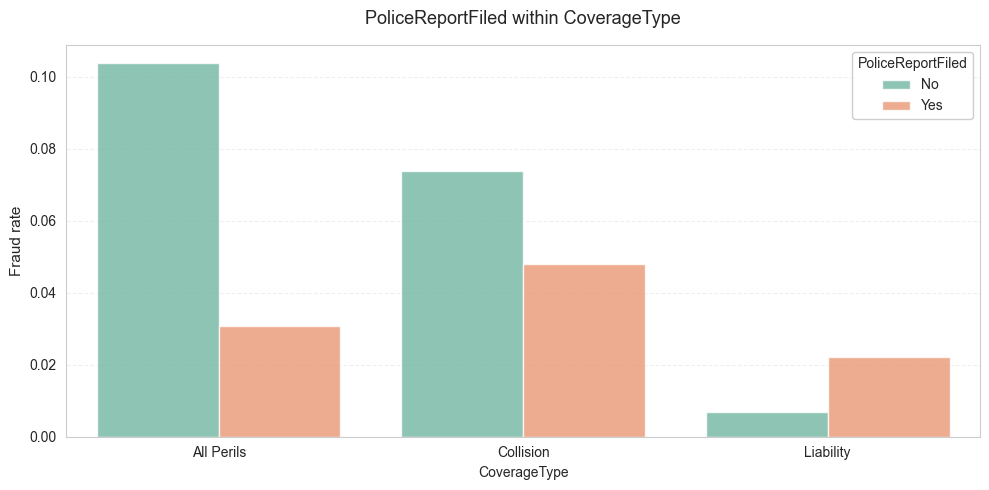

In [64]:
plot_strat(police_x_cov, "CoverageType", "PoliceReportFiled",
          title="PoliceReportFiled within CoverageType")

In [65]:
# how mnay liability + police report cases?

tmp = df.groupby(["CoverageType","PoliceReportFiled"])["FraudFound_P"].agg(
    fraud_cases="sum", n="size", fraud_rate="mean"
).reset_index()
tmp

,CoverageType,PoliceReportFiled,fraud_cases,n,fraud_rate
0,All Perils,No,448,4318,0.103752
1,All Perils,Yes,4,130,0.030769
2,Collision,No,425,5754,0.073862
3,Collision,Yes,10,208,0.048077
4,Liability,No,34,4919,0.006912
5,Liability,Yes,2,90,0.022222


In [66]:
# sport_sedan_mismatch within CoverageType

mismatch_x_cov = strat_fraud(df, by="sport_sedan_mismatch", strat="CoverageType", min_count=50)
mismatch_x_cov

,CoverageType,sport_sedan_mismatch,fraud_cases,count,fraud_rate
0,All Perils,False,452,4448,0.101619
1,Collision,False,435,5962,0.072962
3,Liability,True,36,4987,0.007219


In [67]:
pd.crosstab(df["sport_sedan_mismatch"], df["CoverageType"], normalize="index")
pd.crosstab(df["sport_sedan_mismatch"], df["CoverageType"])

CoverageType,All Perils,Collision,Liability
sport_sedan_mismatch,,,
False,4448,5962,22
True,0,0,4987


`sport_sedan_mismatch` is almost deterministic given `CoverageType` (True appears only under `Liability`), so a meaningful within-stratum comparison is not possible. We therefore exclude it from stratified checks and treat it as a potential product/proxy artifact to revisit during ablation.


In [68]:
# VehicleGroup within VehiclePrice

vech_x_price = strat_fraud(df, by="VehicleGroup", strat="VehiclePrice", min_count=50)
vech_x_price

,VehiclePrice,VehicleGroup,fraud_cases,count,fraud_rate
14,more than 69000,Sport,48,358,0.134078
15,more than 69000,Utility,41,338,0.121302
11,less than 20000,Sedan,103,1093,0.094236
6,40000 to 59000,Sedan,29,420,0.069048
13,more than 69000,Sedan,100,1467,0.068166
0,20000 to 29000,Sedan,421,8072,0.052156
3,30000 to 39000,Sedan,174,3521,0.049418
8,60000 to 69000,Sedan,4,84,0.047619


In [69]:
tmp = strat_fraud(df, by="VehicleGroup", strat=["VehiclePrice", "CoverageType"], min_count=50)
tmp

,VehiclePrice,CoverageType,VehicleGroup,fraud_cases,count,fraud_rate
10,40000 to 59000,All Perils,Sedan,12,78,0.153846
29,more than 69000,Collision,Sport,48,348,0.137931
27,more than 69000,All Perils,Utility,38,294,0.129252
25,more than 69000,All Perils,Sedan,64,506,0.126482
21,less than 20000,All Perils,Sedan,87,764,0.113874
0,20000 to 29000,All Perils,Sedan,195,2061,0.094614
12,40000 to 59000,Collision,Sedan,15,159,0.094340
28,more than 69000,Collision,Sedan,32,396,0.080808
8,30000 to 39000,Collision,Sedan,111,1386,0.080087
5,30000 to 39000,All Perils,Sedan,50,658,0.075988


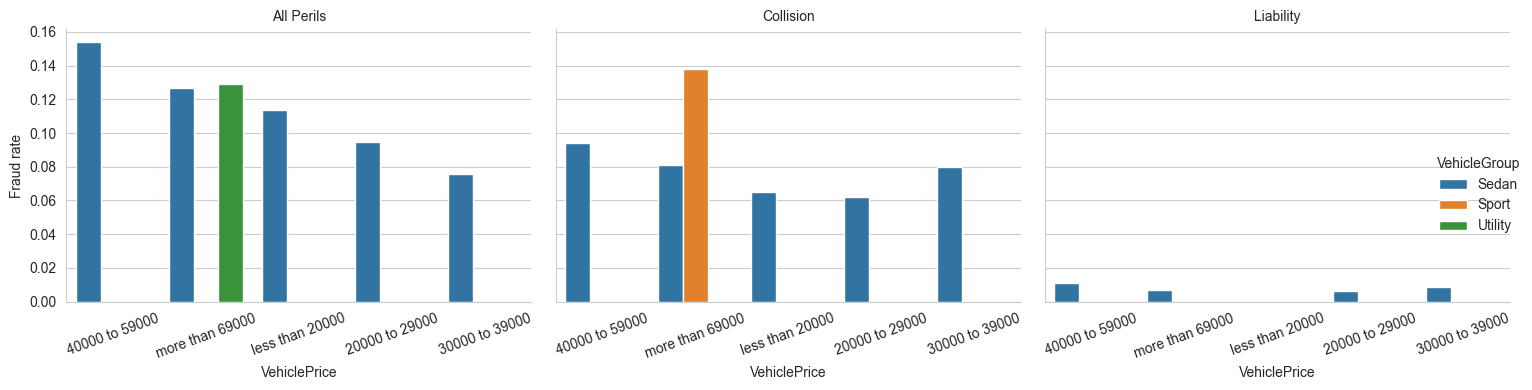

In [70]:
g = sns.catplot(
    data=tmp,
    x="VehiclePrice",
    y="fraud_rate",
    hue="VehicleGroup",
    col="CoverageType",
    kind="bar",
    height=4,
    aspect=1.2
)
g.set_titles("{col_name}")
g.set_axis_labels("VehiclePrice", "Fraud rate")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

### Stratified checks insights

#### `Fault` within `CoverageType`

- The difference between `Policy Holder` vs `Third Party` remains **large within each coverage segment**.
- This suggests `Fault` is not merely a proxy for `CoverageType` and provides additional separation beyond baseline differences.
- The magnitude varies by coverage type (strongest under `All Perils` / `Collision`, lower overall under `Liability` due to its low base fraud rate).

#### `AgentType` within `CoverageType`

- `External` agents show higher fraud rates than `Internal` **within the same coverage type** (where counts allow comparison).
- This supports the interpretation that `AgentType` captures an **operational / workflow / channel** effect, not only differences between coverage segments.
- Caution: `Internal` is a small minority group, so estimates are noisier and should not be overinterpreted.

#### `PoliceReportFiled` within `AccidentArea` and within `CoverageType`

- The pattern `PoliceReportFiled = Yes` → **lower** fraud rate persists within `Urban` and also within each `CoverageType`.
- This indicates the relationship is not explained purely by location mix or coverage mix.
- However, `Yes` buckets are relatively small, so this should be treated as a weak/uncertain signal rather than a strong rule.

**Small-count note:** the `Liability` + `PoliceReportFiled=Yes` subgroup contains only **2 fraud cases out of 90** (fraud_rate ≈ 2.22%).
Given the very low base rate under `Liability` (~0.69%), such relative jumps can be driven by small counts and/or selection effects rather than a stable relationship.

#### `VehicleGroup` within (`VehiclePrice` × `CoverageType`)

- After stratifying by both price bucket and coverage type, **non-sedan vehicle groups appear mostly in the highest price bucket** (`more than 69000`),
  while most other strata are dominated by `Sedan`.
- Within `Collision` and `VehiclePrice > 69000`, `Sport` shows a high fraud rate (≈ 13.8%, n≈348), while the corresponding `Sedan` rate is lower.
- This suggests the earlier “Sport is high-risk” signal is **concentrated in a specific intersection** (high price × collision),
  and may reflect either a real risk pattern or a *detection/handling* difference for expensive claims.
- Because many strata have very small or missing counts for `Sport`/`Utility`, conclusions should be phrased as **localized** rather than global.

**Note:** `sport_sedan_mismatch` is almost deterministic given `CoverageType` (True appears only under `Liability`), so a meaningful within-stratum comparison is not possible.
We therefore exclude it from stratified checks and treat it as a potential product/proxy artifact to revisit during ablation.

**Takeaway:** Stratification confirms that several prominent marginal patterns (`Fault`, `AgentType`) are not purely artifacts of coverage/location base-rate mixing. `PoliceReportFiled` shows a directional trend (Yes → lower fraud), but given the very small `Yes` subgroups
At the same time, small subgroup sizes (especially for `Yes` in reports/witnesses and `Internal` agents) require cautious interpretation.

In [71]:
ct_cov_cat = pd.crosstab(
    df["CoverageType"],
    df["VehicleCategory"],
    normalize="index"  # row-normalized: within each CoverageType
)
ct_cov_group = pd.crosstab(
    df["CoverageType"],
    df["VehicleGroup"],
    normalize="index"
)
ct_cat_group = pd.crosstab(df["VehicleCategory"], df["VehicleGroup"])

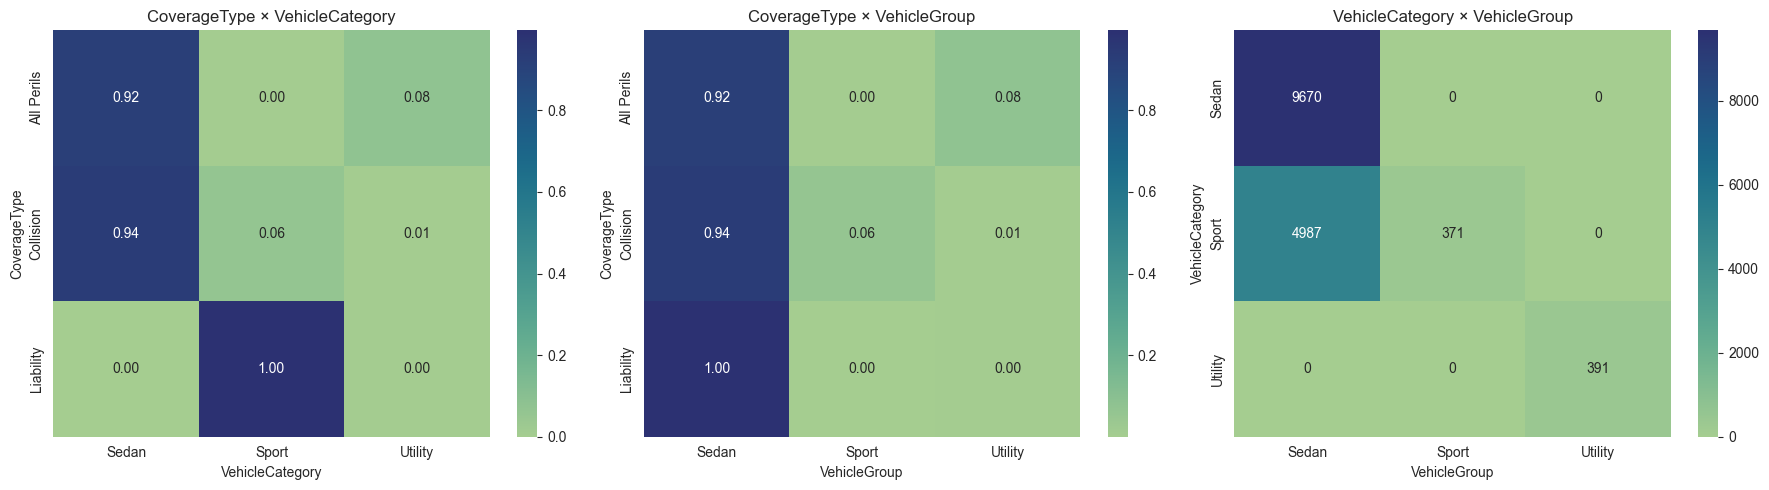

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.heatmap(ct_cov_cat, annot=True, fmt=".2f", cmap="crest", ax=axes[0])
axes[0].set_title("CoverageType × VehicleCategory")
axes[0].set_ylabel("CoverageType")
axes[0].set_xlabel("VehicleCategory")


sns.heatmap(ct_cov_group, annot=True, fmt=".2f", cmap="crest", ax=axes[1])
axes[1].set_title("CoverageType × VehicleGroup")
axes[1].set_ylabel("CoverageType")
axes[1].set_xlabel("VehicleGroup")


sns.heatmap(ct_cat_group, annot=True, fmt="d", cmap="crest", ax=axes[2])
axes[2].set_title("VehicleCategory × VehicleGroup")
axes[2].set_ylabel("VehicleCategory")
axes[2].set_xlabel("VehicleGroup")

plt.tight_layout()
plt.show()

### Structure check: CoverageType vs vehicle descriptors
The heatmaps show near-deterministic relationships: `Liability` is almost exclusively associated with a single vehicle category/group, while `All Perils` and `Collision` contain a broader mix.

This implies that some “vehicle type” variables may act as proxies for product/coverage structure rather than independent risk factors.
Therefore, univariate signals (e.g., AUC for `VehicleCategory` / `VehicleGroup`) should be interpreted cautiously: a strong standalone signal can reflect underlying product segmentation and workflow differences, not necessarily causal fraud drivers.

### Cramér’s V

In [73]:
def cramers_v(x, y):
    """Cramér’s V for two categorical series."""
    ct = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape

    # Bias-corrected Cramér’s V (good default for uneven tables)
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2_corr / denom)

pairs = [
    ("CoverageType", "VehicleCategory"),
    ("CoverageType", "VehicleGroup"),
    ("VehicleCategory", "VehicleGroup"),
    ("AccidentArea", "PolicyType"),
    ("AgentType", "CoverageType"),
    ("Fault", "CoverageType")
    
]

rows = []
for a, b in pairs:
    v = cramers_v(df[a].astype(str), df[b].astype(str))
    rows.append({"var_1": a, "var_2": b, "cramers_v": v})

cramers_table = pd.DataFrame(rows).sort_values("cramers_v", ascending=False)
cramers_table

,var_1,var_2,cramers_v
2,VehicleCategory,VehicleGroup,0.723035
0,CoverageType,VehicleCategory,0.680732
5,Fault,CoverageType,0.206556
1,CoverageType,VehicleGroup,0.191752
4,AgentType,CoverageType,0.082512
3,AccidentArea,PolicyType,0.067572


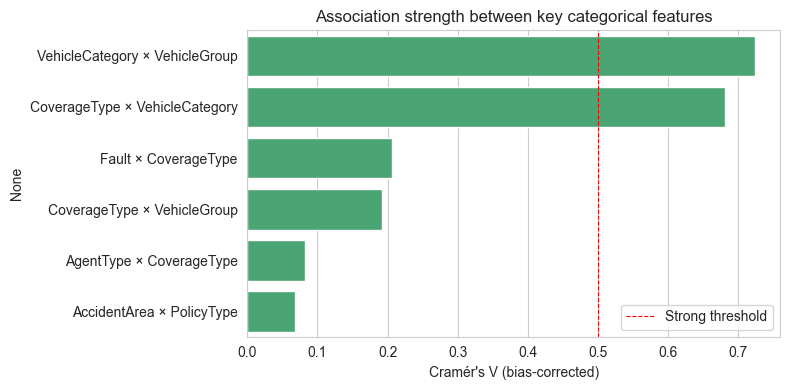

In [74]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=cramers_table,
    y=cramers_table['var_1'] + ' × ' + cramers_table['var_2'],
    x='cramers_v',
    color='mediumseagreen',
    orient='h'
)
plt.xlabel("Cramér's V (bias-corrected)")
plt.title("Association strength between key categorical features")
plt.axvline(0.5, color='red', linestyle='--', linewidth=0.8, label='Strong threshold')
plt.legend()
plt.tight_layout()
plt.show()

#### Cramér’s V: categorical redundancy / proxy check

To complement the univariate AUC scan (feature -> target signal), we quantify **feature–feature dependencies** among key categorical variables using **bias-corrected Cramér’s V** (0 = independent, 1 = near-deterministic association).

**Why this matters:**  
Strong univariate AUC can sometimes be driven by **product segmentation / encoding structure**, rather than an independent behavioral fraud signal. Cramér’s V helps detect:
- redundant encodings (two variables carrying the same information),
- near-deterministic relationships that can amplify “mismatch-style” engineered features,
- proxy risks (a variable acting mainly as a stand-in for product/workflow segmentation).

**Results:**
- `VehicleCategory` × `VehicleGroup`: **0.723** → strong dependency (substantial redundancy).
- `CoverageType` × `VehicleCategory`: **0.681** → strong dependency (coverage is tightly tied to vehicle category mix).
- `Fault` × `CoverageType`: **0.207** → weak–moderate (fault is not merely a proxy for coverage).
- `CoverageType` × `VehicleGroup`: **0.192** → weak–moderate.
- `AgentType` × `CoverageType`: **0.083** → weak.
- `AccidentArea` × `PolicyType`: **0.068** → weak.

**Implication:**  
Vehicle-related descriptors (especially `VehicleCategory`/`VehicleGroup`) are strongly entangled with product structure (`CoverageType`). Therefore, univariate signals involving vehicle fields (and derived mismatch flags) should be interpreted cautiously: strong standalone separation may reflect underlying product segmentation/workflow differences rather than causal fraud drivers. We will revisit these variables during ablation design.

### Question-drivenAblation plan based on process features analysis

Because the dataset lacks official feature documentation, we avoid *feature selection by univariate signal* and instead use **question-driven ablations** to understand *where the predictive power comes from* (product structure vs claim handling/workflow vs claimant/incident characteristics).

**Reference (baseline)** will be trained first. Depending on baseline performance and error patterns, we may adjust the exact ablation sets (e.g., move borderline features between groups), but the guiding questions below remain the same.


#### 0) Baseline (all usable features)
**Goal:** establish a reference point with maximum available information.

- **Target:** `FraudFound_P`
- **Drop from features:** `FraudFound_P`, `PolicyNumber` (identifier)

**Included feature set (baseline):**  
`Month, WeekOfMonth, DayOfWeek, Make, AccidentArea, DayOfWeekClaimed, MonthClaimed, WeekOfMonthClaimed, Sex, MaritalStatus, Age, Fault, PolicyType, VehicleCategory, VehiclePrice, RepNumber, Deductible, DriverRating, Days_Policy_Accident, Days_Policy_Claim, PastNumberOfClaims, AgeOfVehicle, AgeOfPolicyHolder, PoliceReportFiled, WitnessPresent, AgentType, NumberOfSuppliments, AddressChange_Claim, NumberOfCars, Year, VehicleGroup, CoverageType, sport_sedan_mismatch`

> Note: `sport_sedan_mismatch` is treated as an experimental derived feature; we keep it in baseline but may remove it if it behaves like a near-deterministic proxy for product structure.

#### 1) Product-agnostic ablation (remove product/coverage structure)
**Question:** *If the model does not know the insurance product/coverage segmentation, do operational/behavioral signals still carry predictive power?*

- **Remove (product/coverage layer):**  
`PolicyType, CoverageType, VehicleCategory, VehicleGroup, VehiclePrice, sport_sedan_mismatch`
- **Keep (everything else, except target/ID):**  
time/calendar, demographics, claim handling/process features, incident context, history

#### 2) Process-agnostic ablation (remove operational/workflow signals)
**Question:** *If the model does not know how the claim was handled (workflow/triage), can it still predict fraud from product + claimant/incident characteristics?*

- **Remove (process/workflow/handling layer):**  
`AgentType, RepNumber, PoliceReportFiled, WitnessPresent, Days_Policy_Accident, Days_Policy_Claim, NumberOfSuppliments`
- **Keep:**  
product/vehicle structure (`PolicyType, CoverageType, VehicleCategory, VehicleGroup, VehiclePrice`), plus claimant/incident/time/history features (`Fault, AccidentArea, PastNumberOfClaims, ...`)

> Important: some variables (e.g., `Fault`) may be determined at different stages in different real-world workflows. We keep them for now and will revisit after baseline results.


**How we will use these results:**  
We will compare model performance (and stability across time splits) between scenarios to infer whether performance is driven mainly by **product segmentation**, **process/handling proxies**, or more general **behavioral/incident signals**. The objective is interpretability and robustness, not aggressive feature pruning.

### Time-features sanity

In [75]:
# is there dependensy between Month and MonthClaimed?
# counnt lag in month
month_map = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
             "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

df['month_num'] = df['Month'].map(month_map)
df['claimed_num'] = df['MonthClaimed'].map(month_map)
df['claim_lag_months'] = (df['claimed_num'] - df['month_num']) % 12  # модуль 12 для wrap-around
lag_counts = df['claim_lag_months'].value_counts().sort_index()

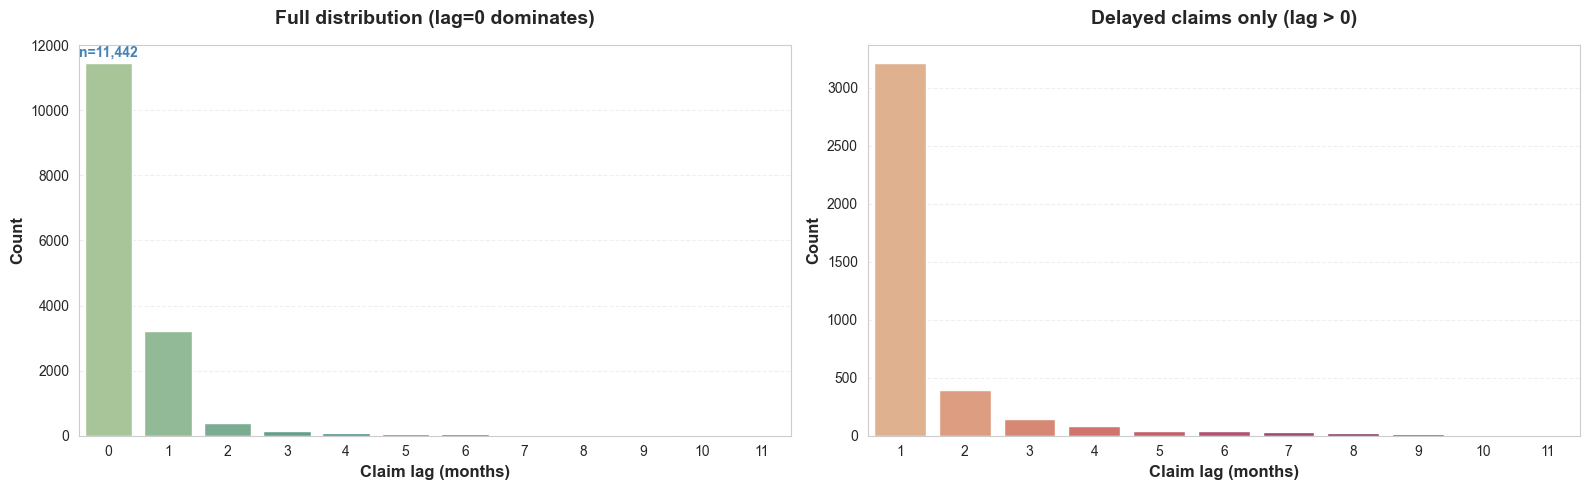


 Summary:
Same-month claims (lag=0): 11,442 (74.2%)
Delayed claims (lag>0): 3,977 (25.8%)


In [76]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: full distribution
sns.barplot(x=lag_counts.index, y=lag_counts.values, 
            palette='crest', ax=axes[0], hue=lag_counts.index, legend=False)
axes[0].set_xlabel("Claim lag (months)", fontsize=12, weight='bold')
axes[0].set_ylabel("Count", fontsize=12, weight='bold')
axes[0].set_title("Full distribution (lag=0 dominates)", fontsize=14, weight='bold', pad=15)
axes[0].set_xticks(range(12))
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_axisbelow(True)

# Add text annotation for lag=0
axes[0].text(0, lag_counts[0] + 200, f'n={lag_counts[0]:,}', 
             ha='center', fontsize=10, weight='bold', color='steelblue')

# Right: zoom at lag > 0
tail = lag_counts[lag_counts.index > 0]
sns.barplot(x=tail.index, y=tail.values, 
            palette='flare', ax=axes[1], hue=tail.index, legend=False)
axes[1].set_xlabel("Claim lag (months)", fontsize=12, weight='bold')
axes[1].set_ylabel("Count", fontsize=12, weight='bold')
axes[1].set_title("Delayed claims only (lag > 0)", fontsize=14, weight='bold', pad=15)
axes[1].set_xticks(range(len(tail)))
axes[1].set_xticklabels(tail.index)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_axisbelow(True)
   
plt.tight_layout()
plt.show()

# summary stats
total = len(df)
same_month = lag_counts[0]
delayed = total - same_month
print(f"\n Summary:")
print(f"Same-month claims (lag=0): {same_month:,} ({same_month/total*100:.1f}%)")
print(f"Delayed claims (lag>0): {delayed:,} ({delayed/total*100:.1f}%)")

In [77]:
# let's chekc if lag claim is connected to fraud rate and how

df["claim_lag_months"] = (df["claimed_num"] - df["month_num"]) % 12

lag_tab = (
    df.groupby("claim_lag_months")["FraudFound_P"]
      .agg(n="size", fraud_cases="sum", fraud_rate="mean")
      .reset_index()
      .sort_values("claim_lag_months")
)

lag_tab_50 = lag_tab[lag_tab["n"] >= 50]

lag_tab_50

,claim_lag_months,n,fraud_cases,fraud_rate
0,0,11442,633,0.055322
1,1,3211,224,0.069760
2,2,390,41,0.105128
3,3,145,11,0.075862
4,4,80,6,0.075000


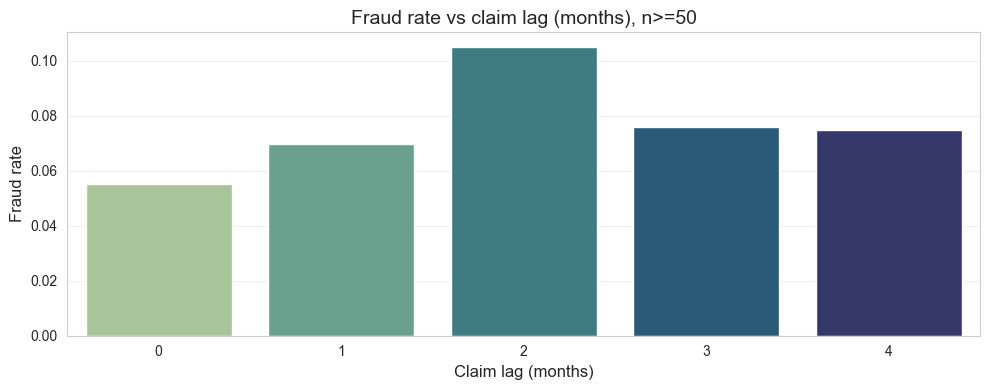

In [78]:
plt.figure(figsize=(10, 4))
sns.barplot(data=lag_tab_50, 
            x="claim_lag_months", 
            y="fraud_rate", 
            hue="claim_lag_months",
            palette="crest",
            legend=False)

plt.title("Fraud rate vs claim lag (months), n>=50", fontsize=14)
plt.ylabel("Fraud rate", fontsize=12)
plt.xlabel("Claim lag (months)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [79]:
# fraud_rate for lag>=2 may be noisy due to small n
# contingency table: lag × fraud status

ct = pd.crosstab(df['claim_lag_months'], df['FraudFound_P'])
chi2, p_value, dof, expected = chi2_contingency(ct)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("Significant association between lag and fraud (p < 0.05)")
else:
    print("No significant association (p >= 0.05)")

Chi-square statistic: 30.64
P-value: 0.0013
Degrees of freedom: 11
Significant association between lag and fraud (p < 0.05)


In [80]:
# let's test if we can turn that statistic significance into feature and how/why
# 2×2 chi-square (lag=0 vs lag>0)

df["lag_bin_2"] = (df["claim_lag_months"] > 0).map({False: "lag=0", True: "lag>0"})

ct2 = pd.crosstab(df["lag_bin_2"], df["FraudFound_P"])
ct2

FraudFound_P,0,1
lag_bin_2,,
lag=0,10809,633
lag>0,3687,290


In [81]:
chi2, p_value, dof, expected = chi2_contingency(ct2)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("Significant association between lag and fraud (p < 0.05)")
else:
    print("No significant association (p >= 0.05)")

Chi-square statistic: 15.93
P-value: 0.0001
Degrees of freedom: 1
Significant association between lag and fraud (p < 0.05)


In [82]:
rate = (df.groupby("lag_bin_2")["FraudFound_P"]
          .mean()
          .rename("fraud_rate"))
count = df["lag_bin_2"].value_counts().rename("n")
summary2 = pd.concat([count, rate], axis=1).loc[["lag=0", "lag>0"]]
summary2["lift_vs_lag0"] = summary2["fraud_rate"] / summary2.loc["lag=0","fraud_rate"]
summary2

,n,fraud_rate,lift_vs_lag0
lag_bin_2,,,
lag=0,11442,0.055322,1.000000
lag>0,3977,0.072919,1.318077


In [83]:
# 3 bins

def lag_bucket(x):
    if x == 0: return "0"
    if x == 1: return "1"
    return "2+"

df["lag_bin_3"] = df["claim_lag_months"].apply(lag_bucket)

ct3 = pd.crosstab(df["lag_bin_3"], df["FraudFound_P"]).reindex(["0","1","2+"])
ct3

FraudFound_P,0,1
lag_bin_3,,
0,10809,633
1,2987,224
2+,700,66


In [84]:
chi2, p_value, dof, expected = chi2_contingency(ct3)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("Significant association between lag and fraud (p < 0.05)")
else:
    print("No significant association (p >= 0.05)")

summary3 = (df.groupby("lag_bin_3")["FraudFound_P"]
              .agg(n="size", fraud_rate="mean")
              .reindex(["0","1","2+"]))
summary3["lift_vs_0"] = summary3["fraud_rate"] / summary3.loc["0","fraud_rate"]
summary3

Chi-square statistic: 19.19
P-value: 0.0001
Degrees of freedom: 2
Significant association between lag and fraud (p < 0.05)


,n,fraud_rate,lift_vs_0
lag_bin_3,,,
0,11442,0.055322,1.000000
1,3211,0.069760,1.260973
2+,766,0.086162,1.557447


### Time sanity check: `Month` vs `MonthClaimed` (claim delay proxy)

**Goal.** Validate that the time-related fields are logically consistent and quantify the delay between the accident month and the claim filing month.  
This serves two purposes:
1) **Sanity check:** ensure there are no impossible patterns (e.g., claims systematically "before" accidents).
2) **Feature hypothesis:** delayed reporting may correlate with fraud behavior (e.g., opportunistic claims, more time to prepare a story).


#### Observations
- Most claims are filed **in the same month** as the accident (lag = 0 dominates).
- A meaningful minority of claims have **lag > 0**, forming a long tail.

#### Fraud association check (lag vs target)
We aggregated fraud rates by `claim_lag_months` and tested whether the distribution of fraud differs by lag group using a **chi-square test of independence**.

- The association is **statistically significant** (p < 0.05).
- Fraud rate increases with longer delays (e.g., `lag=1` higher than `lag=0`, and `lag>=2` highest), although tail bins are smaller.

#### Feature decision (EDA hypothesis → to be validated in modeling)
We propose two encodings for claim delay:

1) `lag_bin_2`: **lag = 0 vs lag > 0**  
   - Very robust, minimal complexity.

2) `lag_bin_3`: **0 vs 1 vs 2+ months**  
   - Captures a monotonic risk pattern while keeping bins coarse.

**Next step (Modeling/FE):** We will include *both* variants as alternative features and compare them in the baseline model (and/or a small ablation test) to select the more stable option under the chosen evaluation protocol.

In [85]:
# making dat features!

# month name -> month number
month_map = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,
             "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}

df["month_num"]   = df["Month"].map(month_map)
df["claimed_num"] = df["MonthClaimed"].map(month_map)

# circular month lag (wrap-around)
df["claim_lag_months"] = (df["claimed_num"] - df["month_num"]) % 12

#  binning options
df["lag_bin_2"] = np.where(df["claim_lag_months"] == 0, "lag=0", "lag>0")

df["lag_bin_3"] = pd.cut(
    df["claim_lag_months"],
    bins=[-0.5, 0.5, 1.5, 12],  # boundaries
    labels=["0", "1", "2+"],
    include_lowest=True
)

# make them categorical (is nice for modeling / memory)
df["lag_bin_2"] = df["lag_bin_2"].astype("category")
df["lag_bin_3"] = df["lag_bin_3"].astype("category")

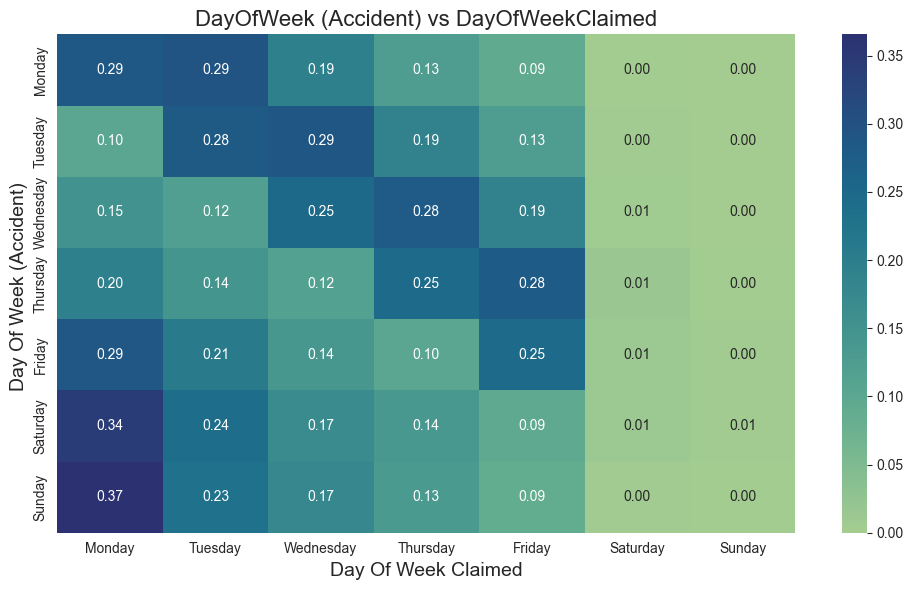

In [86]:
# DayOfWeek vs DayOfWeekClaimed
# check the logic of “claim more often on weekdays” and whether there are any strange jumps

dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

ct = pd.crosstab(df["DayOfWeek"], df["DayOfWeekClaimed"], normalize="index")
ct = ct.reindex(index=dow_order, columns=dow_order)

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='.2f', cmap="crest", vmin=0, vmax=np.nanmax(ct.values))
plt.title("DayOfWeek (Accident) vs DayOfWeekClaimed", size=16)
plt.xlabel("Day Of Week Claimed", size=14)
plt.ylabel("Day Of Week (Accident) ", size=14)
plt.tight_layout()
plt.show()

#### DayOfWeek vs DayOfWeekClaimed (weekday vs weekend filing) 

A normalized cross-tab heatmap shows a strong weekday filing pattern:
- `DayOfWeekClaimed` on **Saturday/Sunday is near-zero** across all accident weekdays.
- Most claims are filed on weekdays, with a diagonal-ish structure suggesting many claims are filed close to the accident day (but not necessarily same day).

**Interpretation:** This looks operationally plausible (office/agent workflow). Rare weekend filings likely represent exceptional processing or data quirks; we do not see a reasdon for further investigation.

In [87]:
# how many applications were submitted in the same month/day/week? 

same_month = (df["Month"] == df["MonthClaimed"]).mean()
same_dow = (df["DayOfWeek"] == df["DayOfWeekClaimed"]).mean()
same_wom = (df["WeekOfMonth"] == df["WeekOfMonthClaimed"]).mean()

same_month, same_dow, same_wom

(np.float64(0.74207147026396),
 np.float64(0.20137492703806992),
 np.float64(0.46066541280238665))

#### Same-period alignment (accident vs claim)
We also computed the fraction of claims filed in the *same* time bucket as the accident:

- Same month: **74.2%**
- Same day-of-week: **20.1%**
- Same week-of-month: **46.1%**

Interpretation: same-month dominance supports the month-lag analysis. Low same-day-of-week alignment is expected due to weekday-focused filing workflow (claims are rarely filed on weekends) and does not imply long delays by itself. Week-of-month alignment is a coarse sanity check and less interpretable than direct month-lag features.

## <a id="target-distribution-peak-behaviour"></a>Target distribution & peak behaviour

Goal: re-check the target base rate and verify that the fraud signal is not driven only by a single time slice (e.g., a specific year) or a single dominant segment.

We visualize:
1) Overall fraud rate and fraud rate by `Year` (baseline stability check).
2) Fraud rate by key segments (`CoverageType`, `AccidentArea`, `Fault`) to show that base rates differ by segment.
   This helps interpret univariate signals: a strong feature may reflect segmentation/base-rate differences rather than an independent fraud driver.

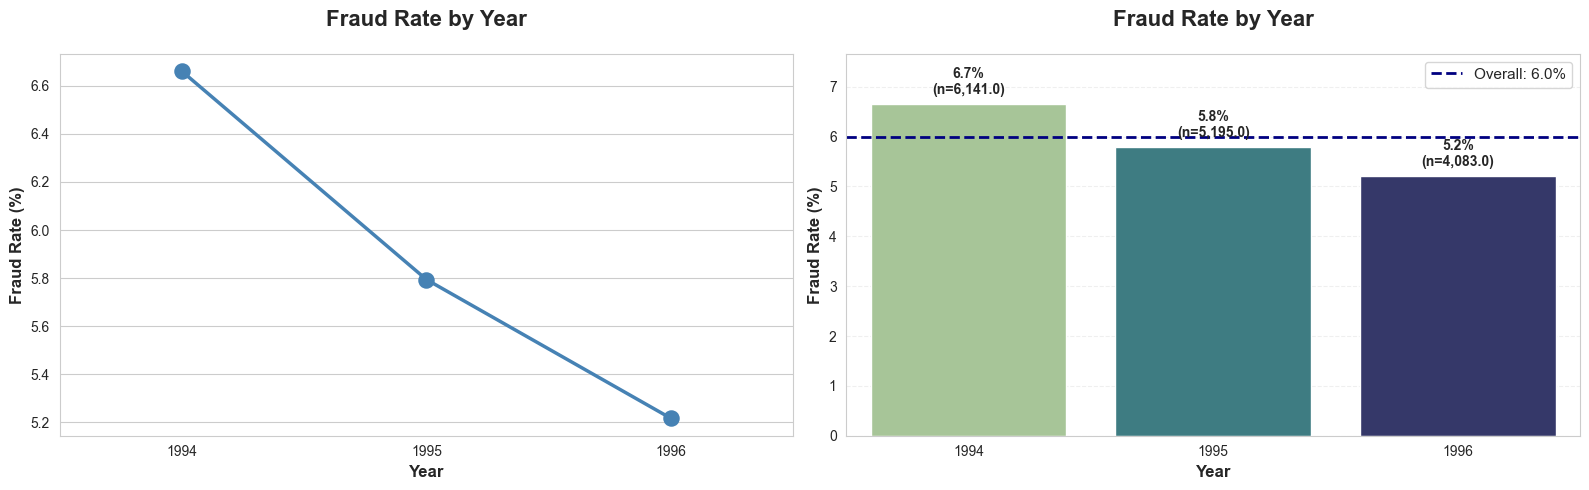


 Fraud Rate Summary:
Overall: 5.99%

By Year:
 Year  fraud_pct    n
 1994   6.660153 6141
 1995   5.794033 5195
 1996   5.216752 4083


In [88]:
overall_fraud_rate = df['FraudFound_P'].mean()

fraud_by_year = df.groupby('Year')['FraudFound_P'].agg(['mean', 'count']).reset_index()
fraud_by_year.columns = ['Year', 'fraud_rate', 'n']
fraud_by_year['fraud_pct'] = fraud_by_year['fraud_rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# LEFT: Overall fraud rate (simple bar or text display)
sns.pointplot(data=fraud_by_year, x='Year', y='fraud_pct', 
              color='steelblue', markers='o', linestyles='-', 
              markersize=10, linewidth=2.5, ax=axes[0],
              err_kws={'linewidth': 2})
axes[0].set_xlabel("Year", fontsize=12, weight='bold')
axes[0].set_ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
axes[0].set_title("Fraud Rate by Year", fontsize=16, weight='bold', pad=20)

# RIGHT: Fraud rate by Year
sns.barplot(data=fraud_by_year, x='Year', y='fraud_pct', 
            palette='crest', ax=axes[1], hue='Year', legend=False)

# Add horizontal line for overall fraud rate
axes[1].axhline(overall_fraud_rate * 100, color='navy', linestyle='--', 
                linewidth=2, label=f'Overall: {overall_fraud_rate:.1%}')

# Add value labels on bars
for i, row in fraud_by_year.iterrows():
    axes[1].text(i, row['fraud_pct'] + 0.2, 
                f"{row['fraud_pct']:.1f}%\n(n={row['n']:,})", 
                ha='center', fontsize=10, weight='bold')

axes[1].set_xlabel("Year", fontsize=12, weight='bold')
axes[1].set_ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
axes[1].set_title("Fraud Rate by Year", fontsize=16, weight='bold', pad=20)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, max(fraud_by_year['fraud_pct']) * 1.15)

plt.tight_layout()
plt.show()

# Print summary table
print("\n Fraud Rate Summary:")
print(f"Overall: {overall_fraud_rate:.2%}")
print("\nBy Year:")
print(fraud_by_year[['Year', 'fraud_pct', 'n']].to_string(index=False))

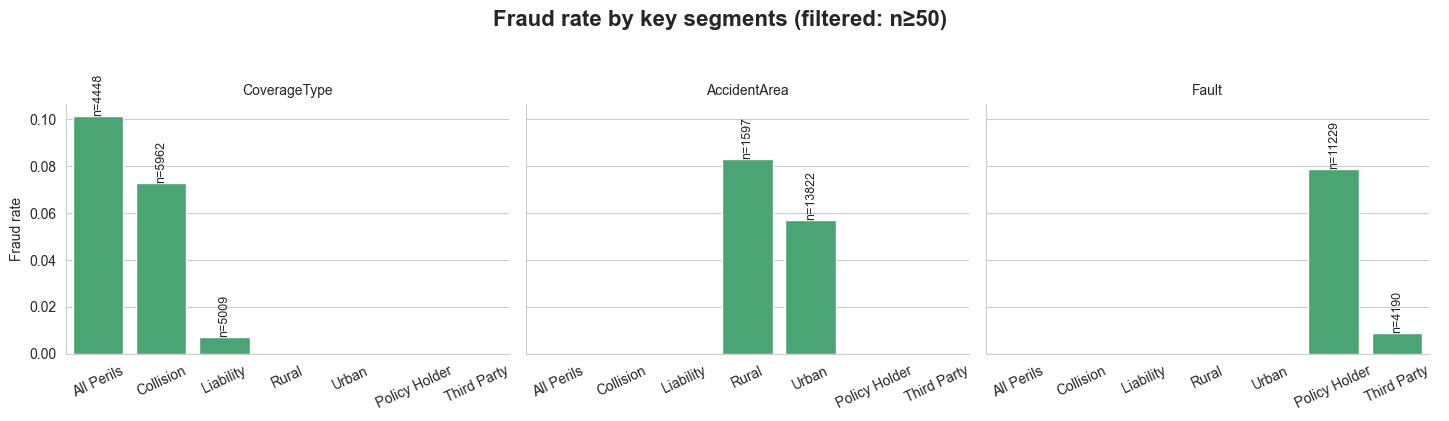

In [89]:
# fraud rate by segments CoverageType / AccidentArea / Fault

seg_cols = ["CoverageType", "AccidentArea", "Fault"]

seg_tables = []
for col in seg_cols:
    tmp = (df.assign(FraudFound_P=df["FraudFound_P"].astype(int))
             .groupby(col, dropna=False)
             .agg(n=("FraudFound_P","size"), fraud_rate=("FraudFound_P","mean"))
             .reset_index()
             .rename(columns={col:"segment_value"}))
    tmp["segment"] = col
    seg_tables.append(tmp)

seg_df = pd.concat(seg_tables, ignore_index=True)

# drop tiny groups for readability
min_n = 50
seg_df_plot = seg_df[seg_df["n"] >= min_n].copy()

g = sns.catplot(
    data=seg_df_plot,
    x="segment_value", y="fraud_rate",
    col="segment",
    kind="bar",
    color="mediumseagreen",
    col_wrap=3,
    height=4, aspect=1.2,
    sharey=True
)

g.set_axis_labels("", "Fraud rate")
g.set_titles("{col_name}")

# rotate x labels + annotate n
for ax, seg in zip(g.axes.flatten(), seg_cols):
    ax.tick_params(axis="x", rotation=25)
    sub = seg_df_plot[seg_df_plot["segment"] == seg].reset_index(drop=True)
    for p, (_, row) in zip(ax.patches, sub.iterrows()):
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height(),
            f"n={int(row['n'])}",
            ha="center", va="bottom", fontsize=9, rotation=90
        )

g.fig.suptitle(f"Fraud rate by key segments (filtered: n≥{min_n})", y=1.04, fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

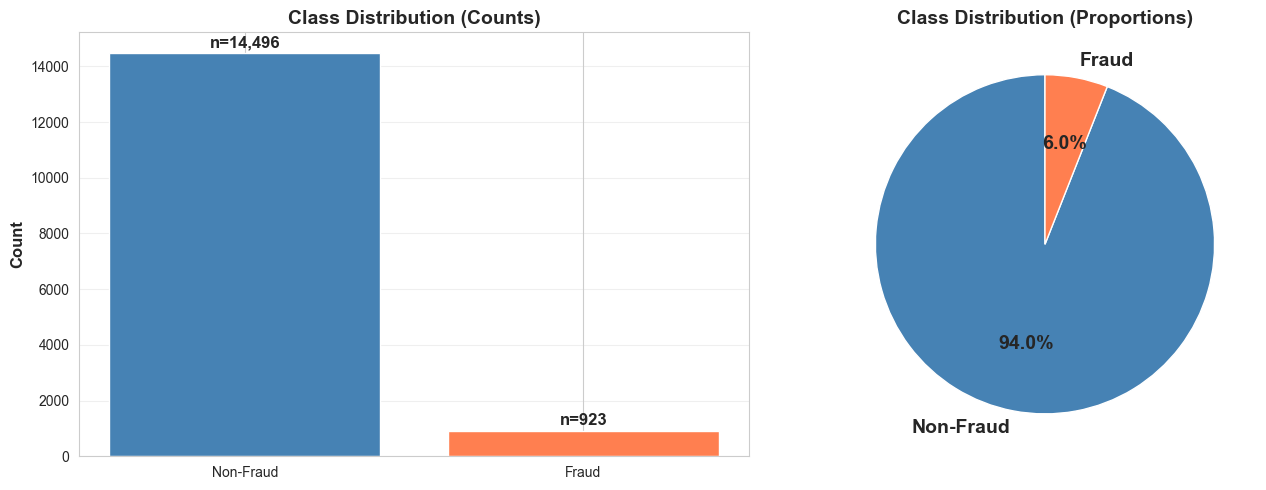


Class Imbalance Ratio: 15.7:1 (non-fraud : fraud)


In [90]:
# class imbalance visual

fraud_counts = df['FraudFound_P'].value_counts()
fraud_pct = df['FraudFound_P'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, 
           color=['steelblue', 'coral'])
for i, (label, count) in enumerate(zip(['Non-Fraud', 'Fraud'], fraud_counts.values)):
    axes[0].text(i, count + 200, f'n={count:,}', 
                ha='center', fontsize=12, weight='bold')
axes[0].set_ylabel("Count", fontsize=12, weight='bold')
axes[0].set_title("Class Distribution (Counts)", fontsize=14, weight='bold')
axes[0].grid(axis='y', alpha=0.3)


axes[1].pie(fraud_pct.values, labels=['Non-Fraud', 'Fraud'], 
           autopct='%1.1f%%', colors=['steelblue', 'coral'],
           startangle=90, textprops={'fontsize': 14, 'weight': 'bold'})
axes[1].set_title("Class Distribution (Proportions)", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Ratio: {fraud_counts[0] / fraud_counts[1]:.1f}:1 (non-fraud : fraud)")

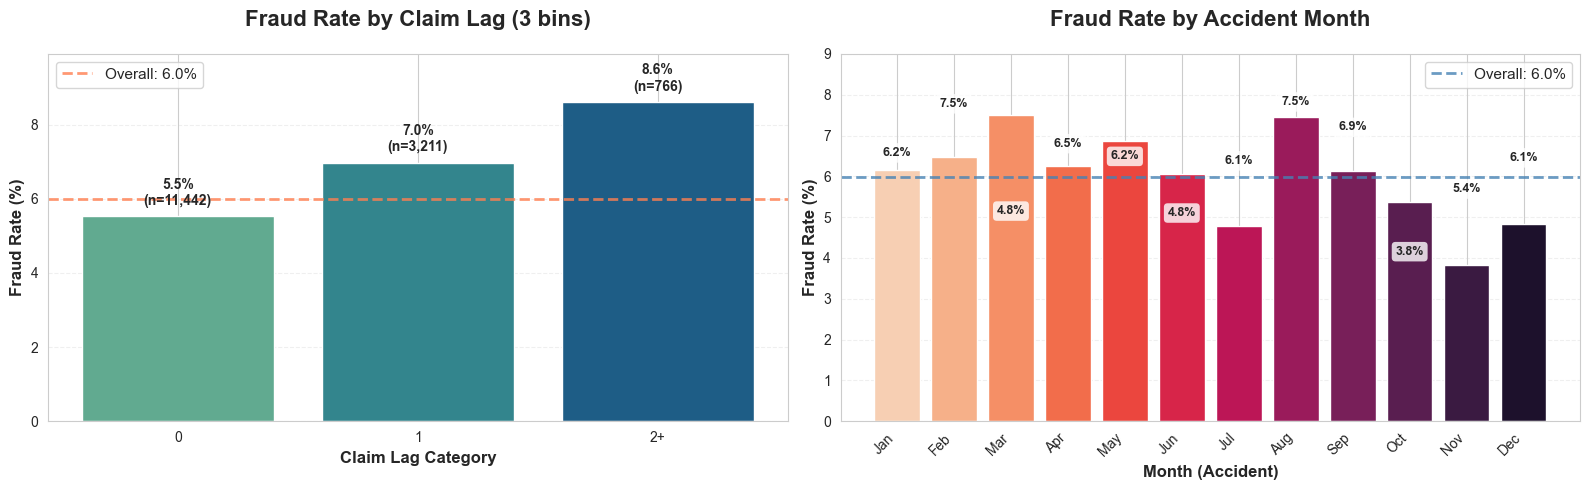


Fraud Rate by Claim Lag:
lag_bin_3  fraud_pct     n
        0   5.532250 11442
        1   6.976020  3211
       2+   8.616188   766

Fraud Rate by Accident Month:
Month  fraud_pct    n
  Jan   6.165840 1411
  Feb   6.477093 1266
  Mar   7.500000 1360
  Apr   6.250000 1280
  May   6.876372 1367
  Jun   6.056018 1321
  Jul   4.777070 1256
  Aug   7.453416 1127
  Sep   6.129032 1240
  Oct   5.363985 1305
  Nov   3.830142 1201
  Dec   4.824903 1285


In [91]:
# fraud rates
fraud_by_lag = df.groupby('lag_bin_3', observed=False)['FraudFound_P'].agg(['mean', 'count']).reset_index()
fraud_by_lag.columns = ['lag_bin_3', 'fraud_rate', 'n']
fraud_by_lag['fraud_pct'] = fraud_by_lag['fraud_rate'] * 100

fraud_by_month = df.groupby('Month')['FraudFound_P'].agg(['mean', 'count']).reset_index()
fraud_by_month.columns = ['Month', 'fraud_rate', 'n']
fraud_by_month['fraud_pct'] = fraud_by_month['fraud_rate'] * 100

# Month order
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fraud_by_month['Month'] = pd.Categorical(fraud_by_month['Month'], categories=month_order, ordered=True)
fraud_by_month = fraud_by_month.sort_values('Month')

# Overall fraud rate for reference
overall_fraud_rate = df['FraudFound_P'].mean() * 100


fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# LEFT: Fraud rate by lag_bin_3
axes[0].bar(fraud_by_lag['lag_bin_3'], fraud_by_lag['fraud_pct'], 
           color=sns.color_palette('crest', len(fraud_by_lag)))

axes[0].axhline(overall_fraud_rate, color='coral', linestyle='--', 
                linewidth=2, label=f'Overall: {overall_fraud_rate:.1f}%', alpha=0.8)

for i, row in fraud_by_lag.iterrows():
    axes[0].text(i, row['fraud_pct'] + 0.3, 
                f"{row['fraud_pct']:.1f}%\n(n={row['n']:,})", 
                ha='center', fontsize=10, weight='bold')

axes[0].set_xlabel("Claim Lag Category", fontsize=12, weight='bold')
axes[0].set_ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
axes[0].set_title("Fraud Rate by Claim Lag (3 bins)", fontsize=16, weight='bold', pad=20)
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(fraud_by_lag['fraud_pct']) * 1.15)

# RIGHT: Fraud rate by Month (accident)
bars = axes[1].bar(range(len(fraud_by_month)), fraud_by_month['fraud_pct'], 
                   color=sns.color_palette('rocket_r', len(fraud_by_month)))

axes[1].axhline(overall_fraud_rate, color='steelblue', linestyle='--', 
                linewidth=2, label=f'Overall: {overall_fraud_rate:.1f}%', alpha=0.8)

for i, row in fraud_by_month.iterrows():
    axes[1].text(i, row['fraud_pct'] + 0.25, 
                f"{row['fraud_pct']:.1f}%", 
                ha='center', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='none', alpha=0.8))

axes[1].set_xlabel("Month (Accident)", fontsize=12, weight='bold')
axes[1].set_ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
axes[1].set_title("Fraud Rate by Accident Month", fontsize=16, weight='bold', pad=20)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_xticks(range(len(fraud_by_month)))
axes[1].set_xticklabels(fraud_by_month['Month'], rotation=45, ha='right')
axes[1].set_ylim(0, max(fraud_by_month['fraud_pct']) * 1.2)  # чуть больше места для labels

plt.tight_layout()
plt.show()

print("\nFraud Rate by Claim Lag:")
print(fraud_by_lag[['lag_bin_3', 'fraud_pct', 'n']].to_string(index=False))
print("\nFraud Rate by Accident Month:")
print(fraud_by_month[['Month', 'fraud_pct', 'n']].to_string(index=False))

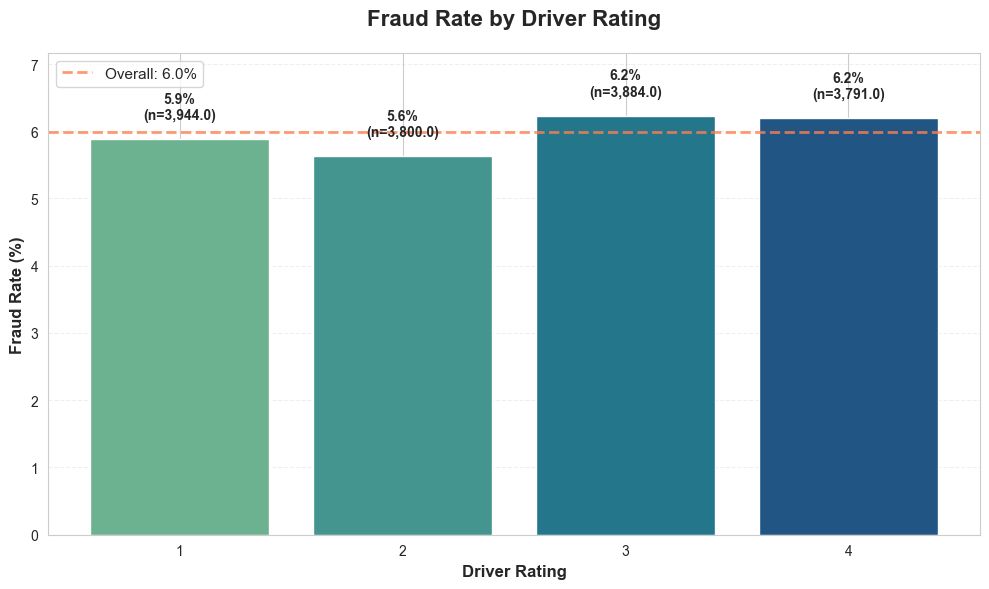


 Fraud Rate by Driver Rating:
 DriverRating  fraud_pct    n
            1   5.882353 3944
            2   5.631579 3800
            3   6.230690 3884
            4   6.198892 3791


In [92]:
# DriverRating and Fraud

fraud_by_rating = df.groupby('DriverRating', observed=False)['FraudFound_P'].agg(['mean', 'count']).reset_index()
fraud_by_rating.columns = ['DriverRating', 'fraud_rate', 'n']
fraud_by_rating['fraud_pct'] = fraud_by_rating['fraud_rate'] * 100
fraud_by_rating = fraud_by_rating.sort_values('DriverRating')  # гарантируем порядок 1,2,3,4



plt.figure(figsize=(10, 6))
plt.bar(range(len(fraud_by_rating)), fraud_by_rating['fraud_pct'], 
       color=sns.color_palette('crest', len(fraud_by_rating)))

plt.axhline(overall_fraud_rate, color='coral', linestyle='--', 
            linewidth=2, label=f'Overall: {overall_fraud_rate:.1f}%', alpha=0.8)

for i, row in fraud_by_rating.iterrows():
    plt.text(i, row['fraud_pct'] + 0.3, 
            f"{row['fraud_pct']:.1f}%\n(n={row['n']:,})", 
            ha='center', fontsize=10, weight='bold')

plt.xlabel("Driver Rating", fontsize=12, weight='bold')
plt.ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
plt.title("Fraud Rate by Driver Rating", fontsize=16, weight='bold', pad=20)
plt.xticks(range(len(fraud_by_rating)), fraud_by_rating['DriverRating'])
plt.legend(loc='best', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(fraud_by_rating['fraud_pct']) * 1.15)
plt.tight_layout()
plt.show()

print(f"\n Fraud Rate by Driver Rating:")
print(fraud_by_rating[['DriverRating', 'fraud_pct', 'n']].to_string(index=False))

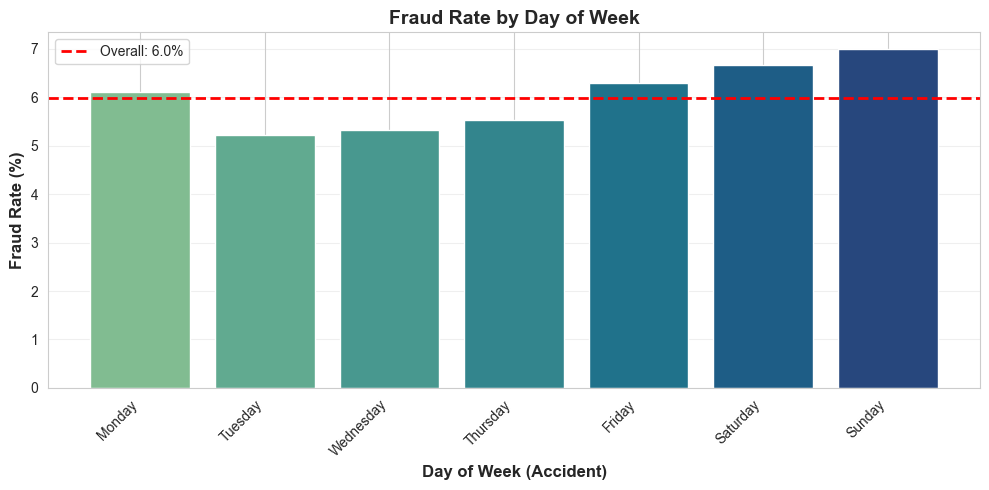

In [93]:
fraud_by_dow = df.groupby('DayOfWeek', observed=False)['FraudFound_P'].agg(['mean', 'count']).reset_index()
fraud_by_dow.columns = ['DayOfWeek', 'fraud_rate', 'n']
fraud_by_dow['fraud_pct'] = fraud_by_dow['fraud_rate'] * 100

# Reorder days
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fraud_by_dow['DayOfWeek'] = pd.Categorical(fraud_by_dow['DayOfWeek'], categories=dow_order, ordered=True)
fraud_by_dow = fraud_by_dow.sort_values('DayOfWeek')

# Simple barplot
plt.figure(figsize=(10, 5))
plt.bar(fraud_by_dow['DayOfWeek'], fraud_by_dow['fraud_pct'], 
        color=sns.color_palette('crest', len(fraud_by_dow)))
plt.axhline(overall_fraud_rate, color='red', linestyle='--', linewidth=2, 
            label=f'Overall: {overall_fraud_rate:.1f}%')
plt.xlabel("Day of Week (Accident)", fontsize=12, weight='bold')
plt.ylabel("Fraud Rate (%)", fontsize=12, weight='bold')
plt.title("Fraud Rate by Day of Week", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


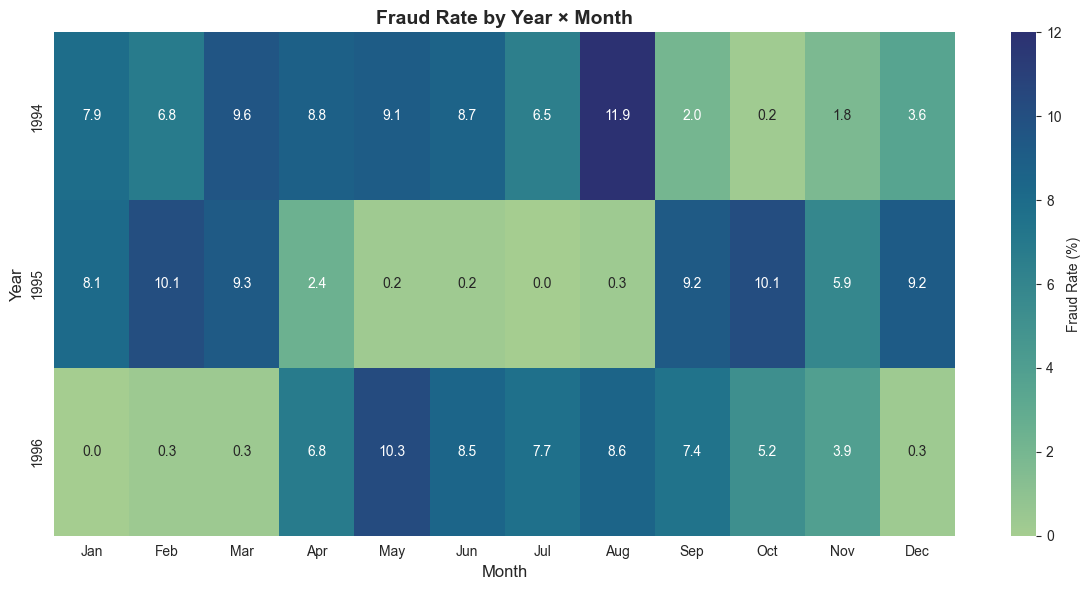

In [94]:
# Fraud rate stability check: Year × Month heatmap to check it for anomaly

fraud_year_month = df.groupby(['Year', 'Month'], observed=False)['FraudFound_P'].mean().reset_index()
fraud_year_month['fraud_pct'] = fraud_year_month['FraudFound_P'] * 100

# Pivot for heatmap
heatmap_data = fraud_year_month.pivot(index='Year', columns='Month', values='fraud_pct')
heatmap_data = heatmap_data[month_order]  # reorder columns

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='crest', 
            vmin=0, vmax=12, cbar_kws={'label': 'Fraud Rate (%)'})
plt.title("Fraud Rate by Year × Month", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.tight_layout()
plt.show()

### Target Distribution & Peak Behaviour Summary:

**Overall prevalence.** The target is imbalanced: overall fraud rate is **~6.0%** (n_fraud ≈ 922, n_non_fraud ≈ 14,497).

**Temporal drift (Year).** Fraud rate shows a mild downward trend across years:
- **1994:** ~6.7% (n ≈ 6,141)  
- **1995:** ~5.8% (n ≈ 5,195)  
- **1996:** ~5.2% (n ≈ 4,083)  

This suggests modest base-rate drift over time, supporting a time-aware evaluation design (e.g., chronological train/test split or temporal cross-validation).

**Base-rate differences across key segments.** Fraud prevalence differs substantially by major business segments:
- **CoverageType:** `All Perils` (~ 10.2%) > `Collision` (~ 7.3%) >> `Liability` (~ 0.7%, very low base rate).
- **AccidentArea:** `Rural` (~ 8.3%) shows higher fraud rate than `Urban` (~ 5.3%).
- **Fault:** `Policy Holder` (~ 9.5%) shows much higher fraud rate than `Third Party` (~ 1.0%).

These base-rate shifts explain part of marginal feature signals and motivate stratified sanity checks to distinguish real fraud drivers from product/coverage segmentation effects.

**Seasonality (Month).** Fraud rate varies by accident month (range: 3.8% in Nov to 7.5% in Aug). Peaks observed in **Mar (~7.5%)** and **Aug (~7.5%)**, while Nov (~3.8%) and Dec (~4.8%) show lower rates.  

`DriverRating` does **not appear to be a strong fraud signal** in this data. This may indicate that fraud behaviour is orthogonal to driving quality or rating is primarily a pricing/risk variable for accident severity, not fraud propensity.

A **Year × Month heatmap** reveals that patterns are **mostly stable** but show some noise in smaller cells (e.g., 1996-specific fluctuations). Therefore, month effects should be treated as **contextual signals** rather than deterministic rules, and may benefit from interaction with other features (e.g., weather-related claim types).

**Day-of-week pattern.** Fraud rate by day of week shows **minimal variation** (range: ~5.5%–6.5%), with no strong operational artifacts detected. This suggests claim processing workflow does not systematically bias fraud prevalence by weekday.

## <a id="eda-conclusions"></a>EDA Conclusions

### 1) Dataset & target in one glance
- The dataset covers **1994–1996** and contains a mix of **product/vehicle descriptors**, **claim context**, **operational/process fields**, and **time-related attributes**.
- The target is **imbalanced**: overall fraud prevalence is **~6%**, so evaluation must use metrics suitable for imbalance (ROC-AUC/PR-AUC + recall-oriented reporting).

### 2) Target stability & “peak behaviour”
- Fraud rate shows **mild downward drift by year** (1994 > 1995 > 1996), indicating base-rate change over time → supports a **time-aware split** (e.g., train on earlier years, test on later year).
- Fraud prevalence varies across major business segments (base-rate shifts):
  - **CoverageType:** `All Perils` > `Collision` >> `Liability` (very low base rate)
  - **AccidentArea:** `Rural` higher than `Urban`
  - **Fault:** `Policy Holder` much higher than `Third Party`
  These differences explain part of the marginal signals and motivate stratified sanity checks.

### 3) Data quality / consistency checks
- **Age inconsistency:** `Age == 0` occurs systematically and maps perfectly to `AgeOfPolicyHolder = "16 to 17"`.  
  → `AgeOfPolicyHolder` is the **more reliable** age representation; `Age` requires special handling in FE.
- Redundant / duplicate feature: we detected `BasePolicy` and `CoverageType`were identical so we removed the duplicate to avoid multicollinearity and reduce noise in downstream modeling.
- **Time sanity:** Accident vs claimed timestamps behave realistically:
  - Claims are rarely filed on weekends (near-zero `Saturday/Sunday` for `DayOfWeekClaimed`), consistent with historical offline workflows.
  - Most claims are filed quickly: **~74% same-month**, **~26% delayed**.
  - One feature 

### 4) Strong structural dependencies
- Univariate screening (ROC-AUC per feature) highlighted **CoverageType** and vehicle descriptors as strong standalone predictors.  
  However, given the strong interdependence between these variables, part of this signal likely reflects **product segmentation / base-rate structure** rather than independent fraud mechanisms.
- High Cramér’s V for **CoverageType × VehicleCategory (~0.68)** and strong dependence between **VehicleCategory × VehicleGroup (~0.72)**.
- This implies that some “vehicle type” variables can act as **proxies for product/coverage structure**, not purely independent risk factors.
- The engineered feature `sport_sedan_mismatch` is **almost deterministic given CoverageType** (appears only under `Liability`), so within-stratum comparisons are not meaningful → treat as a **proxy/artifact candidate** and evaluate only via ablation (not as a “standalone discovery”).

### 5) Signals that persist within strata
Stratified checks indicate several patterns are **not explained purely by coverage/location mix**:
- `Fault`: large separation persists **within each CoverageType**.
- `AgentType`: `External` tends to show higher fraud within the same coverage segment (where counts allow), suggesting a workflow/channel effect.
- `PoliceReportFiled`: the “Yes → lower fraud” pattern broadly persists within Urban and within CoverageType, but `Yes` groups are smaller → treat as a **weaker** signal.

### 6) Claim delay as a robust candidate feature
- We derived a simple claim delay feature (`claim_lag_bin`) from `Month` vs `MonthClaimed`.
- Fraud rate increases with delay:
  - `lag = 0` < `lag = 1` < `lag ≥ 2` (monotonic increase), and chi-square tests show **significant association (p < 0.001)**.
- We will validate **two compact encodings** in modeling (ablation): a 2-bin version (`lag=0 vs lag>0`) and a 3-bin version (`0 / 1 / 2+`), preferring the simplest stable option.

### 7) Modeling implications (what EDA tells us to do next)
- Use **time-based evaluation** aligned with year drift (e.g., train on 2 years, test on the next).
- Be cautious with **product-structure proxies** (CoverageType / VehicleCategory / VehicleGroup / mismatch-like artifacts) and avoid over-engineering derived features.
- Keep a clear separation between:
  - **Product structure features** (coverage/vehicle)
  - **Process/operational features** (agent, police report, witnesses, timing)
  - **Behavioral/context features** (fault, area, etc.)
- Validate the role of these groups via a **small ablation plan (3 scenarios)** rather than many micro-tests, to avoid overfitting and keep the capstone scope reasonable.

**Next step:** proceed to Feature Engineering (FE) with a leakage-safe, reproducible preprocessing pipeline, and evaluate feature groups with the planned ablations.


In [95]:
df.to_csv('data_claim', index=False)